# Maximum Mean Discrepancy Score - Gaussian smearing

In [1]:
import wandb
import os
import numpy as np
import matplotlib.pyplot as plt
import sys
import sklearn
import sklearn.metrics as metrics
import scipy.stats as stats
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from datetime import date,datetime
import shutil
from data_loader import HDF5Dataset, BatchLoader, BatchLoaderTwoFiles, BatchLoaderTwoFiles_high_level, BatchLoaderTwoFilesFixSplitTrain_high_level

from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score

from scipy.stats import wasserstein_distance
from geomloss import SamplesLoss

mean_mmd_scores_every_hl_feature_separately_normalized = []
median_mmd_scores_every_hl_feature_separately_normalized = []
std_mmd_scores_every_hl_feature_separately_normalized = []
max_mmd_scores_every_hl_feature_separately_normalized = []
min_mmd_scores_every_hl_feature_separately_normalized = []

energy_distance_mmd = SamplesLoss("energy")

n_hl_features = 106

permutations_1: [array([     0,      1,      2, ..., 249995, 249996, 249999]), array([     1,      2,      3, ..., 249993, 249994, 249999]), array([     0,      1,      2, ..., 249994, 249996, 249999]), array([     0,      1,      2, ..., 249997, 249998, 249999]), array([     0,      1,      2, ..., 249997, 249998, 249999])]
len(permutations_1) : 5
permutations_2: [array([     0,      2,      3, ..., 249997, 249998, 249999]), array([     0,      1,      2, ..., 249997, 249998, 249999]), array([     0,      1,      2, ..., 249996, 249998, 249999]), array([     0,      1,      4, ..., 249997, 249998, 249999]), array([     0,      1,      2, ..., 249997, 249998, 249999])]
len(permutations_2) : 5
[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode


In [2]:
# Loading the Datasets 

def threshold(x, threshmin, newval=0.0):
    x[x < threshmin] = newval
    return x

def tf_core25_thresh(x):
    if len(x.shape) == 4:
        return threshold(x[:, :, 13:38, 11:36], threshmin=0.25, newval=0.0)
    else: 
        return threshold(x[:, 13:38, 11:36], threshmin=0.25, newval=0.0)


    
    


def loading_hl_features(file_path_dict):
    
    label_array_orig = np.array([])
    energy_sum_array_orig = np.array([])
    layer_energy_summed_over_xy_array_orig = np.array([])
    layer_energy_summed_over_yz_array_orig = np.array([])
    layer_energy_summed_over_zx_array_orig = np.array([])
    layer_energy_summed_over_xy_list_orig = []
    layer_energy_summed_over_yz_list_orig = []
    layer_energy_summed_over_zx_list_orig = []
    _0Moment_x_array_orig = np.array([])
    _0Moment_y_array_orig = np.array([])
    _0Moment_z_array_orig = np.array([])
    _1Moment_x_array_orig = np.array([])
    _1Moment_y_array_orig = np.array([])
    _1Moment_z_array_orig = np.array([])
    occupancy_array_orig = np.array([])
    hl_feature_list_orig = []
    hl_feature_array_orig = np.array([])

    label_array_trafo = np.array([])    
    energy_sum_array_trafo = np.array([])
    layer_energy_summed_over_xy_array_trafo = np.array([])
    layer_energy_summed_over_yz_array_trafo = np.array([])
    layer_energy_summed_over_zx_array_trafo = np.array([])
    layer_energy_summed_over_xy_list_trafo = []
    layer_energy_summed_over_yz_list_trafo = []
    layer_energy_summed_over_zx_list_trafo = []
    _0Moment_x_array_trafo = np.array([])
    _0Moment_y_array_trafo = np.array([])
    _0Moment_z_array_trafo = np.array([])
    _1Moment_x_array_trafo = np.array([])
    _1Moment_y_array_trafo = np.array([])
    _1Moment_z_array_trafo = np.array([])
    occupancy_array_trafo = np.array([])
    hl_feature_list_trafo = []
    hl_feature_array_trafo = np.array([])
    
    array_dict = {
            
            "label_array_orig" : label_array_orig,
            "energy_sum_array_orig" : energy_sum_array_orig,
            "layer_energy_summed_over_xy_array_orig" : layer_energy_summed_over_xy_array_orig,
            "layer_energy_summed_over_yz_array_orig" : layer_energy_summed_over_yz_array_orig,
            "layer_energy_summed_over_zx_array_orig" : layer_energy_summed_over_zx_array_orig,
            "layer_energy_summed_over_xy_list_orig" : layer_energy_summed_over_xy_list_orig,
            "layer_energy_summed_over_yz_list_orig" : layer_energy_summed_over_yz_list_orig,
            "layer_energy_summed_over_zx_list_orig" : layer_energy_summed_over_zx_list_orig,
            "_0Moment_x_array_orig" : _0Moment_x_array_orig,
            "_0Moment_y_array_orig" : _0Moment_y_array_orig,
            "_0Moment_z_array_orig" : _0Moment_z_array_orig,
            "_1Moment_x_array_orig" : _1Moment_x_array_orig,
            "_1Moment_y_array_orig" : _1Moment_y_array_orig,
            "_1Moment_z_array_orig" : _1Moment_z_array_orig,
            "occupancy_array_orig" : occupancy_array_orig,
            "hl_feature_list_orig" : hl_feature_list_orig,
            "hl_feature_array_orig" : hl_feature_array_orig,
        
            "label_array_trafo" : label_array_trafo,
            "energy_sum_array_trafo" : energy_sum_array_trafo,
            "layer_energy_summed_over_xy_array_trafo" : layer_energy_summed_over_xy_array_trafo,
            "layer_energy_summed_over_yz_array_trafo" : layer_energy_summed_over_yz_array_trafo,
            "layer_energy_summed_over_zx_array_trafo" : layer_energy_summed_over_zx_array_trafo,
            "layer_energy_summed_over_xy_list_trafo" : layer_energy_summed_over_xy_list_trafo,
            "layer_energy_summed_over_yz_list_trafo" : layer_energy_summed_over_yz_list_trafo,
            "layer_energy_summed_over_zx_list_trafo" : layer_energy_summed_over_zx_list_trafo,
            "_0Moment_x_array_trafo" : _0Moment_x_array_trafo,
            "_0Moment_y_array_trafo" : _0Moment_y_array_trafo,
            "_0Moment_z_array_trafo" : _0Moment_z_array_trafo,
            "_1Moment_x_array_trafo" : _1Moment_x_array_trafo,
            "_1Moment_y_array_trafo" : _1Moment_y_array_trafo,
            "_1Moment_z_array_trafo" : _1Moment_z_array_trafo,
            "occupancy_array_trafo" : occupancy_array_trafo,
            "hl_feature_list_trafo" : hl_feature_list_trafo,
            "hl_feature_array_trafo" : hl_feature_array_trafo,
            
        }
    
    n_split1 = 255000
    n_split2 = 255000
    n_gesamt = n_split1 + n_split2
    training_percentage = 80
    validation_percentage = 10
    test_percentage = 10

    x_size = 25
    y_size = 25
    z_size = 48 

    total_start = datetime.now()

    # Define Parameters - fully_connected NN

    params_fully_connected = {

            "model" : "fully_connected_mip_high_level_with_layer_energies_identische",

            # IO
            "input_path"  : '/beegfs/desy/user/diefenbs/shower_data/pion_uniform_510k_PunchThroughCut70.hdf5',
            "file_path1" : f'{file_path_dict["file_path1"]}',
            "file_path2" : f'{file_path_dict["file_path2"]}',                     
            "file_path3" : f'{file_path_dict["file_path3"]}',
            "file_path4" : f'{file_path_dict["file_path4"]}',                     
            "file_path5" : f'{file_path_dict["file_path5"]}',
            "file_path6" : f'{file_path_dict["file_path6"]}',                         
            "output_path" : '/beegfs/desy/user/schreibj/Hadron_classifier/results/',

            "batch_size" : 1280, #256 baseline 128 1024  6375 1280 12750
            "batch_size2" : 1280,
            "epochs" : 300,
            'no_cuda': False,
            "train_size" : int(n_split1*training_percentage*0.01) , 
            "train_size2" : int(n_split2*training_percentage*0.01) , 
            "validation_size" : int(n_split1*validation_percentage*0.01) , 
            "validation_size2" : int(n_split2*validation_percentage*0.01) , 
            "test_size" : int(n_split1*test_percentage*0.01) ,
            "test_size2" :  int(n_split2*test_percentage*0.01) , 
            'shuffle': True,
            "ENR_Cut_Cutoff" : 0.1,
            'lr_fully_connected' : 0.001,
            'opt_fully_connecte' : 'Adam',
            'SafeAfterEpochOnly' : True,
            "save_iter_interval" : 50,
            "wandb_dir" : '/beegfs/desy/user/schreibj/wandb/Hadron_classifier/',
            "plt_after_each_batch" : True,
            "print_after_each_batch" : False,
        }  

    train_loader = BatchLoaderTwoFiles_high_level(file_path1 = params_fully_connected["file_path1"],
                                       file_path2 = params_fully_connected["file_path2"],
                                       train_size = params_fully_connected["train_size"], 
                                       train_size2 = params_fully_connected["train_size2"], 
                                       batch_size = params_fully_connected["batch_size"], 
                                       batch_size2 = params_fully_connected["batch_size2"], 
                                       shuffle=True, 
                                       transform=tf_core25_thresh)

    validation_loader = BatchLoaderTwoFiles_high_level(file_path1 = params_fully_connected["file_path3"],
                                       file_path2 = params_fully_connected["file_path4"],
                                       train_size = params_fully_connected["validation_size"], 
                                       train_size2 = params_fully_connected["validation_size2"], 
                                       batch_size = params_fully_connected["batch_size"], 
                                       batch_size2 = params_fully_connected["batch_size2"], 
                                       shuffle=True, 
                                       transform=tf_core25_thresh)

    test_loader = BatchLoaderTwoFiles_high_level(file_path1 = params_fully_connected["file_path5"],
                                       file_path2 = params_fully_connected["file_path6"],
                                       train_size = params_fully_connected["test_size"], 
                                       train_size2 = params_fully_connected["test_size2"], 
                                       batch_size = params_fully_connected["batch_size"], 
                                       batch_size2 = params_fully_connected["batch_size2"], 
                                       shuffle=True, 
                                       transform=tf_core25_thresh)


    # Check whether actually loaded number of batches fits the expected amount of batches

    print(f'number of train batches: {int(params_fully_connected["train_size"]/params_fully_connected["batch_size"])}')
    print(f'number of validation batches: {int(params_fully_connected["validation_size"]/params_fully_connected["batch_size"])}')
    print(f'number of test batches: {int(params_fully_connected["test_size"]/params_fully_connected["batch_size"])}')


    for batch_idx, (label, energy_sum,layer_energy_summed_over_xy, layer_energy_summed_over_yz, layer_energy_summed_over_zx, _0Moment_x, _0Moment_y, _0Moment_z, _1Moment_x, _1Moment_y, _1Moment_z, occupancy ) in enumerate(train_loader):

            if energy_sum.shape[0]%(params_fully_connected["batch_size"] + params_fully_connected["batch_size2"]) != 0: 
                continue


            #Preparing the high level data - flatten all high level features and concatenate them in one vektor as training input: 
            hl_dict = {
            
            "label" : label.view(params_fully_connected["batch_size"] + params_fully_connected["batch_size2"],-1),
            "energy_sum" : torch.from_numpy(energy_sum).view(params_fully_connected["batch_size"] + params_fully_connected["batch_size2"],-1),
            "layer_energy_summed_over_xy" : torch.from_numpy(layer_energy_summed_over_xy).view(params_fully_connected["batch_size"] + params_fully_connected["batch_size2"],-1),
            "layer_energy_summed_over_yz" : torch.from_numpy(layer_energy_summed_over_yz).view(params_fully_connected["batch_size"] + params_fully_connected["batch_size2"],-1),
            "layer_energy_summed_over_zx" : torch.from_numpy(layer_energy_summed_over_zx).view(params_fully_connected["batch_size"] + params_fully_connected["batch_size2"],-1),
            "_0Moment_x" : torch.from_numpy(_0Moment_x).view(params_fully_connected["batch_size"] + params_fully_connected["batch_size2"],-1),
            "_0Moment_y" : torch.from_numpy(_0Moment_y).view(params_fully_connected["batch_size"] + params_fully_connected["batch_size2"],-1),
            "_0Moment_z" : torch.from_numpy(_0Moment_z).view(params_fully_connected["batch_size"] + params_fully_connected["batch_size2"],-1),
            "_1Moment_x" : torch.from_numpy(_1Moment_x).view(params_fully_connected["batch_size"] + params_fully_connected["batch_size2"],-1),
            "_1Moment_y" : torch.from_numpy(_1Moment_y).view(params_fully_connected["batch_size"] + params_fully_connected["batch_size2"],-1),
            "_1Moment_z" : torch.from_numpy(_1Moment_z).view(params_fully_connected["batch_size"] + params_fully_connected["batch_size2"],-1),
            "occupancy" : torch.from_numpy(occupancy).view(params_fully_connected["batch_size"] + params_fully_connected["batch_size2"],-1),
            #"high_level_tensor" : torch.cat((hl_dict["energy_sum"],hl_dict["layer_energy_summed_over_xy"],hl_dict["layer_energy_summed_over_yz"],hl_dict["layer_energy_summed_over_zx"],hl_dict["_0Moment_x"],hl_dict["_0Moment_y"],hl_dict["_0Moment_z"],hl_dict["_1Moment_x"],hl_dict["_1Moment_y"],hl_dict["_1Moment_z"],hl_dict["occupancy"]),1).float(),
            #"high_level_tensor" : torch.cat(label, energy_sum,layer_energy_summed_over_xy, layer_energy_summed_over_yz, layer_energy_summed_over_zx, _0Moment_x, _0Moment_y, _0Moment_z, _1Moment_x, _1Moment_y, _1Moment_z, occupancy,1).float(),
            
                
            }

            high_level_tensor = torch.cat((hl_dict["energy_sum"],hl_dict["layer_energy_summed_over_xy"],hl_dict["layer_energy_summed_over_yz"],hl_dict["layer_energy_summed_over_zx"],hl_dict["_0Moment_x"],hl_dict["_0Moment_y"],hl_dict["_0Moment_z"],hl_dict["_1Moment_x"],hl_dict["_1Moment_y"],hl_dict["_1Moment_z"],hl_dict["occupancy"]),1).float()

            #ohne layer energies
            #high_level_tensor = torch.cat((energy_sum,_0Moment_x,_0Moment_y,_0Moment_z,_1Moment_x,_1Moment_y,_1Moment_z,occupancy),1).float()

            #ohne layer energy xy,zx
            #high_level_tensor = torch.cat((energy_sum,layer_energy_summed_over_xy,_0Moment_x,_0Moment_y,_0Moment_z,_1Moment_x,_1Moment_y,_1Moment_z,occupancy),1).float()

            if params_fully_connected["plt_after_each_batch"] == True:
                hl_feature_array_orig, hl_feature_array_trafo = append_hl_features_cummulative(array_dict, params_fully_connected, hl_dict, high_level_tensor)
            if batch_idx%10 == 0:
                print(f'batch_idx: {batch_idx}')
                print(f'hl_feature_array_orig.shape: {hl_feature_array_orig.shape}')
                print(f'hl_feature_array_trafo.shape: {hl_feature_array_trafo.shape}')

    return hl_feature_array_orig, hl_feature_array_trafo

def append_hl_features_cummulative(array_dict, params_fully_connected, hl_dict, high_level_tensor):
        
        array_dict["label_array_orig"] = np.append(array_dict["label_array_orig"],hl_dict["label"][0:params_fully_connected["batch_size"]])
        array_dict["energy_sum_array_orig"] = np.append(array_dict["energy_sum_array_orig"],hl_dict["energy_sum"][0:params_fully_connected["batch_size"]])
        array_dict["layer_energy_summed_over_xy_list_orig"].append(hl_dict["layer_energy_summed_over_xy"][0:params_fully_connected["batch_size"]])
        array_dict["layer_energy_summed_over_yz_list_orig"].append(hl_dict["layer_energy_summed_over_yz"][0:params_fully_connected["batch_size"]])
        array_dict["layer_energy_summed_over_zx_list_orig"].append(hl_dict["layer_energy_summed_over_zx"][0:params_fully_connected["batch_size"]])
        
        array_dict["layer_energy_summed_over_xy_array_orig"] = np.vstack(array_dict["layer_energy_summed_over_xy_list_orig"])
        array_dict["layer_energy_summed_over_yz_array_orig"] = np.vstack(array_dict["layer_energy_summed_over_yz_list_orig"])
        array_dict["layer_energy_summed_over_zx_array_orig"] = np.vstack(array_dict["layer_energy_summed_over_zx_list_orig"])
        array_dict["_0Moment_x_array_orig"] = np.append(array_dict["_0Moment_x_array_orig"],hl_dict["_0Moment_x"][0:params_fully_connected["batch_size"]])
        array_dict["_0Moment_y_array_orig"] = np.append(array_dict["_0Moment_y_array_orig"],hl_dict["_0Moment_y"][0:params_fully_connected["batch_size"]])
        array_dict["_0Moment_z_array_orig"] = np.append(array_dict["_0Moment_z_array_orig"],hl_dict["_0Moment_z"][0:params_fully_connected["batch_size"]])
        array_dict["_1Moment_x_array_orig"] = np.append(array_dict["_1Moment_x_array_orig"],hl_dict["_1Moment_x"][0:params_fully_connected["batch_size"]])
        array_dict["_1Moment_y_array_orig"] = np.append(array_dict["_1Moment_y_array_orig"],hl_dict["_1Moment_y"][0:params_fully_connected["batch_size"]])
        array_dict["_1Moment_z_array_orig"] = np.append(array_dict["_1Moment_z_array_orig"],hl_dict["_1Moment_z"][0:params_fully_connected["batch_size"]])
        array_dict["occupancy_array_orig"] = np.append(array_dict["occupancy_array_orig"],hl_dict["occupancy"][0:params_fully_connected["batch_size"]])
        array_dict["hl_feature_list_orig"].append(high_level_tensor[0:params_fully_connected["batch_size"]])
        array_dict["hl_feature_array_orig"] = np.vstack(array_dict["hl_feature_list_orig"])


        array_dict["label_array_trafo"] = np.append(array_dict["label_array_trafo"],hl_dict["label"][params_fully_connected["batch_size"]:])
        array_dict["energy_sum_array_trafo"] = np.append(array_dict["energy_sum_array_trafo"],hl_dict["energy_sum"][params_fully_connected["batch_size"]:])
        array_dict["layer_energy_summed_over_xy_list_trafo"].append(hl_dict["layer_energy_summed_over_xy"][params_fully_connected["batch_size"]:])
        array_dict["layer_energy_summed_over_yz_list_trafo"].append(hl_dict["layer_energy_summed_over_yz"][params_fully_connected["batch_size"]:])
        array_dict["layer_energy_summed_over_zx_list_trafo"].append(hl_dict["layer_energy_summed_over_zx"][params_fully_connected["batch_size"]:])
        array_dict["layer_energy_summed_over_xy_array_trafo"] = np.vstack(array_dict["layer_energy_summed_over_xy_list_trafo"])
        array_dict["layer_energy_summed_over_yz_array_trafo"] = np.vstack(array_dict["layer_energy_summed_over_yz_list_trafo"])
        array_dict["layer_energy_summed_over_zx_array_trafo"] = np.vstack(array_dict["layer_energy_summed_over_zx_list_trafo"])
        array_dict["_0Moment_x_array_trafo"] = np.append(array_dict["_0Moment_x_array_trafo"],hl_dict["_0Moment_x"][params_fully_connected["batch_size"]:])
        array_dict["_0Moment_y_array_trafo"] = np.append(array_dict["_0Moment_y_array_trafo"],hl_dict["_0Moment_y"][params_fully_connected["batch_size"]:])
        array_dict["_0Moment_z_array_trafo"] = np.append(array_dict["_0Moment_z_array_trafo"],hl_dict["_0Moment_z"][params_fully_connected["batch_size"]:])
        array_dict["_1Moment_x_array_trafo"] = np.append(array_dict["_1Moment_x_array_trafo"],hl_dict["_1Moment_x"][params_fully_connected["batch_size"]:])
        array_dict["_1Moment_y_array_trafo"] = np.append(array_dict["_1Moment_y_array_trafo"],hl_dict["_1Moment_y"][params_fully_connected["batch_size"]:])
        array_dict["_1Moment_z_array_trafo"] = np.append(array_dict["_1Moment_z_array_trafo"],hl_dict["_1Moment_z"][params_fully_connected["batch_size"]:])
        array_dict["occupancy_array_trafo"] = np.append(array_dict["occupancy_array_trafo"],hl_dict["occupancy"][params_fully_connected["batch_size"]:])
        array_dict["hl_feature_list_trafo"].append(high_level_tensor[params_fully_connected["batch_size"]:])
        array_dict["hl_feature_array_trafo"] = np.vstack(array_dict["hl_feature_list_trafo"]) 
        
        if params_fully_connected["print_after_each_batch"] == True:
            print(f'label_array_orig.shape: {array_dict["label_array_orig"].shape}')
            print(f'layer_energy_summed_over_xy_array_orig.shape: {array_dict["layer_energy_summed_over_xy_array_orig"].shape}')
            print(f'layer_energy_summed_over_yz_array_orig.shape: {array_dict["layer_energy_summed_over_yz_array_orig"].shape}')
            print(f'layer_energy_summed_over_zx_array_orig.shape: {array_dict["layer_energy_summed_over_zx_array_orig"].shape}')
            print(f'energy_sum_array_orig.shape: {array_dict["energy_sum_array_orig"].shape}')
            print(f'_0Moment_x_array_orig.shape: {array_dict["_0Moment_x_array_orig"].shape}')
            print(f'_0Moment_y_array_orig.shape: {array_dict["_0Moment_y_array_orig"].shape}')
            print(f'_0Moment_z_array_orig.shape: {array_dict["_0Moment_z_array_orig"].shape}')
            print(f'_1Moment_x_array_orig.shape: {array_dict["_1Moment_x_array_orig"].shape}')
            print(f'_1Moment_y_array_orig.shape: {array_dict["_1Moment_y_array_orig"].shape}')
            print(f'_1Moment_z_array_orig.shape: {array_dict["_1Moment_z_array_orig"].shape}')
            print(f'occupancy_array_orig.shape: {array_dict["occupancy_array_orig"].shape}')
            print(f'hl_feature_array_orig.shape: {array_dict["hl_feature_array_orig"].shape}')

            print(f'label_array_trafo.shape: {array_dict["label_array_trafo"].shape}')
            print(f'energy_sum_array_trafo.shape: {array_dict["energy_sum_array_trafo"].shape}')
            print(f'layer_energy_summed_over_xy_array_trafo.shape: {array_dict["layer_energy_summed_over_xy_array_trafo"].shape}')
            print(f'layer_energy_summed_over_yz_array_trafo.shape: {array_dict["layer_energy_summed_over_yz_array_trafo"].shape}')
            print(f'layer_energy_summed_over_zx_array_trafo.shape: {array_dict["layer_energy_summed_over_zx_array_trafo"].shape}')
            print(f'_0Moment_x_array_trafo.shape: {array_dict["_0Moment_x_array_trafo"].shape}')
            print(f'_0Moment_y_array_trafo.shape: {array_dict["_0Moment_y_array_trafo"].shape}')
            print(f'_0Moment_z_array_trafo.shape: {array_dict["_0Moment_z_array_trafo"].shape}')
            print(f'_1Moment_x_array_trafo.shape: {array_dict["_1Moment_x_array_trafo"].shape}')
            print(f'_1Moment_y_array_trafo.shape: {array_dict["_1Moment_y_array_trafo"].shape}')
            print(f'_1Moment_z_array_trafo.shape: {array_dict["_1Moment_z_array_trafo"].shape}')
            print(f'occupancy_array_trafo.shape: {array_dict["occupancy_array_trafo"].shape}')
            print(f'hl_feature_array_trafo.shape: {array_dict["hl_feature_array_trafo"].shape}')
            print(f'label_array_orig: {label_array_orig}')
            print(np.max(array_dict["energy_sum_array_orig"]))
            print(np.min(array_dict["energy_sum_array_orig"]))
            print(f'label_array_trafo: {label_array_trafo}')
            print(np.max(array_dict["energy_sum_array_trafo"]))
            print(np.min(array_dict["energy_sum_array_trafo"])) 
            
            
        return array_dict["hl_feature_array_orig"], array_dict["hl_feature_array_trafo"]    
    
    
    
    
    
    
    
    
    
    
    



def loading_hl_features_five_models(file_path_dict):
    
    label_array_orig_1 = np.array([])
    energy_sum_array_orig_1 = np.array([])
    layer_energy_summed_over_xy_array_orig_1 = np.array([])
    layer_energy_summed_over_yz_array_orig_1 = np.array([])
    layer_energy_summed_over_zx_array_orig_1 = np.array([])
    layer_energy_summed_over_xy_list_orig_1 = []
    layer_energy_summed_over_yz_list_orig_1 = []
    layer_energy_summed_over_zx_list_orig_1 = []
    _0Moment_x_array_orig_1 = np.array([])
    _0Moment_y_array_orig_1 = np.array([])
    _0Moment_z_array_orig_1 = np.array([])
    _1Moment_x_array_orig_1 = np.array([])
    _1Moment_y_array_orig_1 = np.array([])
    _1Moment_z_array_orig_1 = np.array([])
    occupancy_array_orig_1 = np.array([])
    hl_feature_list_orig_1 = []
    hl_feature_array_orig_1 = np.array([])

    label_array_trafo_1 = np.array([])    
    energy_sum_array_trafo_1 = np.array([])
    layer_energy_summed_over_xy_array_trafo_1 = np.array([])
    layer_energy_summed_over_yz_array_trafo_1 = np.array([])
    layer_energy_summed_over_zx_array_trafo_1 = np.array([])
    layer_energy_summed_over_xy_list_trafo_1 = []
    layer_energy_summed_over_yz_list_trafo_1 = []
    layer_energy_summed_over_zx_list_trafo_1 = []
    _0Moment_x_array_trafo_1 = np.array([])
    _0Moment_y_array_trafo_1 = np.array([])
    _0Moment_z_array_trafo_1 = np.array([])
    _1Moment_x_array_trafo_1 = np.array([])
    _1Moment_y_array_trafo_1 = np.array([])
    _1Moment_z_array_trafo_1 = np.array([])
    occupancy_array_trafo_1 = np.array([])
    hl_feature_list_trafo_1 = []
    hl_feature_array_trafo_1 = np.array([])
    
    label_array_orig_2 = np.array([])
    energy_sum_array_orig_2 = np.array([])
    layer_energy_summed_over_xy_array_orig_2 = np.array([])
    layer_energy_summed_over_yz_array_orig_2 = np.array([])
    layer_energy_summed_over_zx_array_orig_2 = np.array([])
    layer_energy_summed_over_xy_list_orig_2 = []
    layer_energy_summed_over_yz_list_orig_2 = []
    layer_energy_summed_over_zx_list_orig_2 = []
    _0Moment_x_array_orig_2 = np.array([])
    _0Moment_y_array_orig_2 = np.array([])
    _0Moment_z_array_orig_2 = np.array([])
    _1Moment_x_array_orig_2 = np.array([])
    _1Moment_y_array_orig_2 = np.array([])
    _1Moment_z_array_orig_2 = np.array([])
    occupancy_array_orig_2 = np.array([])
    hl_feature_list_orig_2 = []
    hl_feature_array_orig_2 = np.array([])

    label_array_trafo_2 = np.array([])    
    energy_sum_array_trafo_2 = np.array([])
    layer_energy_summed_over_xy_array_trafo_2 = np.array([])
    layer_energy_summed_over_yz_array_trafo_2 = np.array([])
    layer_energy_summed_over_zx_array_trafo_2 = np.array([])
    layer_energy_summed_over_xy_list_trafo_2 = []
    layer_energy_summed_over_yz_list_trafo_2 = []
    layer_energy_summed_over_zx_list_trafo_2 = []
    _0Moment_x_array_trafo_2 = np.array([])
    _0Moment_y_array_trafo_2 = np.array([])
    _0Moment_z_array_trafo_2 = np.array([])
    _1Moment_x_array_trafo_2 = np.array([])
    _1Moment_y_array_trafo_2 = np.array([])
    _1Moment_z_array_trafo_2 = np.array([])
    occupancy_array_trafo_2 = np.array([])
    hl_feature_list_trafo_2 = []
    hl_feature_array_trafo_2 = np.array([])
    
    label_array_orig_3 = np.array([])
    energy_sum_array_orig_3 = np.array([])
    layer_energy_summed_over_xy_array_orig_3 = np.array([])
    layer_energy_summed_over_yz_array_orig_3 = np.array([])
    layer_energy_summed_over_zx_array_orig_3 = np.array([])
    layer_energy_summed_over_xy_list_orig_3 = []
    layer_energy_summed_over_yz_list_orig_3 = []
    layer_energy_summed_over_zx_list_orig_3 = []
    _0Moment_x_array_orig_3 = np.array([])
    _0Moment_y_array_orig_3 = np.array([])
    _0Moment_z_array_orig_3 = np.array([])
    _1Moment_x_array_orig_3 = np.array([])
    _1Moment_y_array_orig_3 = np.array([])
    _1Moment_z_array_orig_3 = np.array([])
    occupancy_array_orig_3 = np.array([])
    hl_feature_list_orig_3 = []
    hl_feature_array_orig_3 = np.array([])

    label_array_trafo_3 = np.array([])    
    energy_sum_array_trafo_3 = np.array([])
    layer_energy_summed_over_xy_array_trafo_3 = np.array([])
    layer_energy_summed_over_yz_array_trafo_3 = np.array([])
    layer_energy_summed_over_zx_array_trafo_3 = np.array([])
    layer_energy_summed_over_xy_list_trafo_3 = []
    layer_energy_summed_over_yz_list_trafo_3 = []
    layer_energy_summed_over_zx_list_trafo_3 = []
    _0Moment_x_array_trafo_3 = np.array([])
    _0Moment_y_array_trafo_3 = np.array([])
    _0Moment_z_array_trafo_3 = np.array([])
    _1Moment_x_array_trafo_3 = np.array([])
    _1Moment_y_array_trafo_3 = np.array([])
    _1Moment_z_array_trafo_3 = np.array([])
    occupancy_array_trafo_3 = np.array([])
    hl_feature_list_trafo_3 = []
    hl_feature_array_trafo_3 = np.array([])
    
    label_array_orig_4 = np.array([])
    energy_sum_array_orig_4 = np.array([])
    layer_energy_summed_over_xy_array_orig_4 = np.array([])
    layer_energy_summed_over_yz_array_orig_4 = np.array([])
    layer_energy_summed_over_zx_array_orig_4 = np.array([])
    layer_energy_summed_over_xy_list_orig_4 = []
    layer_energy_summed_over_yz_list_orig_4 = []
    layer_energy_summed_over_zx_list_orig_4 = []
    _0Moment_x_array_orig_4 = np.array([])
    _0Moment_y_array_orig_4 = np.array([])
    _0Moment_z_array_orig_4 = np.array([])
    _1Moment_x_array_orig_4 = np.array([])
    _1Moment_y_array_orig_4 = np.array([])
    _1Moment_z_array_orig_4 = np.array([])
    occupancy_array_orig_4 = np.array([])
    hl_feature_list_orig_4 = []
    hl_feature_array_orig_4 = np.array([])

    label_array_trafo_4 = np.array([])    
    energy_sum_array_trafo_4 = np.array([])
    layer_energy_summed_over_xy_array_trafo_4 = np.array([])
    layer_energy_summed_over_yz_array_trafo_4 = np.array([])
    layer_energy_summed_over_zx_array_trafo_4 = np.array([])
    layer_energy_summed_over_xy_list_trafo_4 = []
    layer_energy_summed_over_yz_list_trafo_4 = []
    layer_energy_summed_over_zx_list_trafo_4 = []
    _0Moment_x_array_trafo_4 = np.array([])
    _0Moment_y_array_trafo_4 = np.array([])
    _0Moment_z_array_trafo_4 = np.array([])
    _1Moment_x_array_trafo_4 = np.array([])
    _1Moment_y_array_trafo_4 = np.array([])
    _1Moment_z_array_trafo_4 = np.array([])
    occupancy_array_trafo_4 = np.array([])
    hl_feature_list_trafo_4 = []
    hl_feature_array_trafo_4 = np.array([])
    
    label_array_orig_5 = np.array([])
    energy_sum_array_orig_5 = np.array([])
    layer_energy_summed_over_xy_array_orig_5 = np.array([])
    layer_energy_summed_over_yz_array_orig_5 = np.array([])
    layer_energy_summed_over_zx_array_orig_5 = np.array([])
    layer_energy_summed_over_xy_list_orig_5 = []
    layer_energy_summed_over_yz_list_orig_5 = []
    layer_energy_summed_over_zx_list_orig_5 = []
    _0Moment_x_array_orig_5 = np.array([])
    _0Moment_y_array_orig_5 = np.array([])
    _0Moment_z_array_orig_5 = np.array([])
    _1Moment_x_array_orig_5 = np.array([])
    _1Moment_y_array_orig_5 = np.array([])
    _1Moment_z_array_orig_5 = np.array([])
    occupancy_array_orig_5 = np.array([])
    hl_feature_list_orig_5 = []
    hl_feature_array_orig_5 = np.array([])

    label_array_trafo_5 = np.array([])    
    energy_sum_array_trafo_5 = np.array([])
    layer_energy_summed_over_xy_array_trafo_5 = np.array([])
    layer_energy_summed_over_yz_array_trafo_5 = np.array([])
    layer_energy_summed_over_zx_array_trafo_5 = np.array([])
    layer_energy_summed_over_xy_list_trafo_5 = []
    layer_energy_summed_over_yz_list_trafo_5 = []
    layer_energy_summed_over_zx_list_trafo_5 = []
    _0Moment_x_array_trafo_5 = np.array([])
    _0Moment_y_array_trafo_5 = np.array([])
    _0Moment_z_array_trafo_5 = np.array([])
    _1Moment_x_array_trafo_5 = np.array([])
    _1Moment_y_array_trafo_5 = np.array([])
    _1Moment_z_array_trafo_5 = np.array([])
    occupancy_array_trafo_5 = np.array([])
    hl_feature_list_trafo_5 = []
    hl_feature_array_trafo_5 = np.array([])
    
    
    
    
    array_dict = {
            
            "label_array_orig_1" : label_array_orig_1,
            "energy_sum_array_orig_1" : energy_sum_array_orig_1,
            "layer_energy_summed_over_xy_array_orig_1" : layer_energy_summed_over_xy_array_orig_1,
            "layer_energy_summed_over_yz_array_orig_1" : layer_energy_summed_over_yz_array_orig_1,
            "layer_energy_summed_over_zx_array_orig_1" : layer_energy_summed_over_zx_array_orig_1,
            "layer_energy_summed_over_xy_list_orig_1" : layer_energy_summed_over_xy_list_orig_1,
            "layer_energy_summed_over_yz_list_orig_1" : layer_energy_summed_over_yz_list_orig_1,
            "layer_energy_summed_over_zx_list_orig_1" : layer_energy_summed_over_zx_list_orig_1,
            "_0Moment_x_array_orig_1" : _0Moment_x_array_orig_1,
            "_0Moment_y_array_orig_1" : _0Moment_y_array_orig_1,
            "_0Moment_z_array_orig_1" : _0Moment_z_array_orig_1,
            "_1Moment_x_array_orig_1" : _1Moment_x_array_orig_1,
            "_1Moment_y_array_orig_1" : _1Moment_y_array_orig_1,
            "_1Moment_z_array_orig_1" : _1Moment_z_array_orig_1,
            "occupancy_array_orig_1" : occupancy_array_orig_1,
            "hl_feature_list_orig_1" : hl_feature_list_orig_1,
            "hl_feature_array_orig_1" : hl_feature_array_orig_1,
        
            "label_array_trafo_1" : label_array_trafo_1,
            "energy_sum_array_trafo_1" : energy_sum_array_trafo_1,
            "layer_energy_summed_over_xy_array_trafo_1" : layer_energy_summed_over_xy_array_trafo_1,
            "layer_energy_summed_over_yz_array_trafo_1" : layer_energy_summed_over_yz_array_trafo_1,
            "layer_energy_summed_over_zx_array_trafo_1" : layer_energy_summed_over_zx_array_trafo_1,
            "layer_energy_summed_over_xy_list_trafo_1" : layer_energy_summed_over_xy_list_trafo_1,
            "layer_energy_summed_over_yz_list_trafo_1" : layer_energy_summed_over_yz_list_trafo_1,
            "layer_energy_summed_over_zx_list_trafo_1" : layer_energy_summed_over_zx_list_trafo_1,
            "_0Moment_x_array_trafo_1" : _0Moment_x_array_trafo_1,
            "_0Moment_y_array_trafo_1" : _0Moment_y_array_trafo_1,
            "_0Moment_z_array_trafo_1" : _0Moment_z_array_trafo_1,
            "_1Moment_x_array_trafo_1" : _1Moment_x_array_trafo_1,
            "_1Moment_y_array_trafo_1" : _1Moment_y_array_trafo_1,
            "_1Moment_z_array_trafo_1" : _1Moment_z_array_trafo_1,
            "occupancy_array_trafo_1" : occupancy_array_trafo_1,
            "hl_feature_list_trafo_1" : hl_feature_list_trafo_1,
            "hl_feature_array_trafo_1" : hl_feature_array_trafo_1,
        
            "label_array_orig_2" : label_array_orig_2,
            "energy_sum_array_orig_2" : energy_sum_array_orig_2,
            "layer_energy_summed_over_xy_array_orig_2" : layer_energy_summed_over_xy_array_orig_2,
            "layer_energy_summed_over_yz_array_orig_2" : layer_energy_summed_over_yz_array_orig_2,
            "layer_energy_summed_over_zx_array_orig_2" : layer_energy_summed_over_zx_array_orig_2,
            "layer_energy_summed_over_xy_list_orig_2" : layer_energy_summed_over_xy_list_orig_2,
            "layer_energy_summed_over_yz_list_orig_2" : layer_energy_summed_over_yz_list_orig_2,
            "layer_energy_summed_over_zx_list_orig_2" : layer_energy_summed_over_zx_list_orig_2,
            "_0Moment_x_array_orig_2" : _0Moment_x_array_orig_2,
            "_0Moment_y_array_orig_2" : _0Moment_y_array_orig_2,
            "_0Moment_z_array_orig_2" : _0Moment_z_array_orig_2,
            "_1Moment_x_array_orig_2" : _1Moment_x_array_orig_2,
            "_1Moment_y_array_orig_2" : _1Moment_y_array_orig_2,
            "_1Moment_z_array_orig_2" : _1Moment_z_array_orig_2,
            "occupancy_array_orig_2" : occupancy_array_orig_2,
            "hl_feature_list_orig_2" : hl_feature_list_orig_2,
            "hl_feature_array_orig_2" : hl_feature_array_orig_2,
        
            "label_array_trafo_2" : label_array_trafo_2,
            "energy_sum_array_trafo_2" : energy_sum_array_trafo_2,
            "layer_energy_summed_over_xy_array_trafo_2" : layer_energy_summed_over_xy_array_trafo_2,
            "layer_energy_summed_over_yz_array_trafo_2" : layer_energy_summed_over_yz_array_trafo_2,
            "layer_energy_summed_over_zx_array_trafo_2" : layer_energy_summed_over_zx_array_trafo_2,
            "layer_energy_summed_over_xy_list_trafo_2" : layer_energy_summed_over_xy_list_trafo_2,
            "layer_energy_summed_over_yz_list_trafo_2" : layer_energy_summed_over_yz_list_trafo_2,
            "layer_energy_summed_over_zx_list_trafo_2" : layer_energy_summed_over_zx_list_trafo_2,
            "_0Moment_x_array_trafo_2" : _0Moment_x_array_trafo_2,
            "_0Moment_y_array_trafo_2" : _0Moment_y_array_trafo_2,
            "_0Moment_z_array_trafo_2" : _0Moment_z_array_trafo_2,
            "_1Moment_x_array_trafo_2" : _1Moment_x_array_trafo_2,
            "_1Moment_y_array_trafo_2" : _1Moment_y_array_trafo_2,
            "_1Moment_z_array_trafo_2" : _1Moment_z_array_trafo_2,
            "occupancy_array_trafo_2" : occupancy_array_trafo_2,
            "hl_feature_list_trafo_2" : hl_feature_list_trafo_2,
            "hl_feature_array_trafo_2" : hl_feature_array_trafo_2,
        
            "label_array_orig_3" : label_array_orig_3,
            "energy_sum_array_orig_3" : energy_sum_array_orig_3,
            "layer_energy_summed_over_xy_array_orig_3" : layer_energy_summed_over_xy_array_orig_3,
            "layer_energy_summed_over_yz_array_orig_3" : layer_energy_summed_over_yz_array_orig_3,
            "layer_energy_summed_over_zx_array_orig_3" : layer_energy_summed_over_zx_array_orig_3,
            "layer_energy_summed_over_xy_list_orig_3" : layer_energy_summed_over_xy_list_orig_3,
            "layer_energy_summed_over_yz_list_orig_3" : layer_energy_summed_over_yz_list_orig_3,
            "layer_energy_summed_over_zx_list_orig_3" : layer_energy_summed_over_zx_list_orig_3,
            "_0Moment_x_array_orig_3" : _0Moment_x_array_orig_3,
            "_0Moment_y_array_orig_3" : _0Moment_y_array_orig_3,
            "_0Moment_z_array_orig_3" : _0Moment_z_array_orig_3,
            "_1Moment_x_array_orig_3" : _1Moment_x_array_orig_3,
            "_1Moment_y_array_orig_3" : _1Moment_y_array_orig_3,
            "_1Moment_z_array_orig_3" : _1Moment_z_array_orig_3,
            "occupancy_array_orig_3" : occupancy_array_orig_3,
            "hl_feature_list_orig_3" : hl_feature_list_orig_3,
            "hl_feature_array_orig_3" : hl_feature_array_orig_3,
        
            "label_array_trafo_3" : label_array_trafo_3,
            "energy_sum_array_trafo_3" : energy_sum_array_trafo_3,
            "layer_energy_summed_over_xy_array_trafo_3" : layer_energy_summed_over_xy_array_trafo_3,
            "layer_energy_summed_over_yz_array_trafo_3" : layer_energy_summed_over_yz_array_trafo_3,
            "layer_energy_summed_over_zx_array_trafo_3" : layer_energy_summed_over_zx_array_trafo_3,
            "layer_energy_summed_over_xy_list_trafo_3" : layer_energy_summed_over_xy_list_trafo_3,
            "layer_energy_summed_over_yz_list_trafo_3" : layer_energy_summed_over_yz_list_trafo_3,
            "layer_energy_summed_over_zx_list_trafo_3" : layer_energy_summed_over_zx_list_trafo_3,
            "_0Moment_x_array_trafo_3" : _0Moment_x_array_trafo_3,
            "_0Moment_y_array_trafo_3" : _0Moment_y_array_trafo_3,
            "_0Moment_z_array_trafo_3" : _0Moment_z_array_trafo_3,
            "_1Moment_x_array_trafo_3" : _1Moment_x_array_trafo_3,
            "_1Moment_y_array_trafo_3" : _1Moment_y_array_trafo_3,
            "_1Moment_z_array_trafo_3" : _1Moment_z_array_trafo_3,
            "occupancy_array_trafo_3" : occupancy_array_trafo_3,
            "hl_feature_list_trafo_3" : hl_feature_list_trafo_3,
            "hl_feature_array_trafo_3" : hl_feature_array_trafo_3,
    
        
            "label_array_orig_4" : label_array_orig_4,
            "energy_sum_array_orig_4" : energy_sum_array_orig_4,
            "layer_energy_summed_over_xy_array_orig_4" : layer_energy_summed_over_xy_array_orig_4,
            "layer_energy_summed_over_yz_array_orig_4" : layer_energy_summed_over_yz_array_orig_4,
            "layer_energy_summed_over_zx_array_orig_4" : layer_energy_summed_over_zx_array_orig_4,
            "layer_energy_summed_over_xy_list_orig_4" : layer_energy_summed_over_xy_list_orig_4,
            "layer_energy_summed_over_yz_list_orig_4" : layer_energy_summed_over_yz_list_orig_4,
            "layer_energy_summed_over_zx_list_orig_4" : layer_energy_summed_over_zx_list_orig_4,
            "_0Moment_x_array_orig_4" : _0Moment_x_array_orig_4,
            "_0Moment_y_array_orig_4" : _0Moment_y_array_orig_4,
            "_0Moment_z_array_orig_4" : _0Moment_z_array_orig_4,
            "_1Moment_x_array_orig_4" : _1Moment_x_array_orig_4,
            "_1Moment_y_array_orig_4" : _1Moment_y_array_orig_4,
            "_1Moment_z_array_orig_4" : _1Moment_z_array_orig_4,
            "occupancy_array_orig_4" : occupancy_array_orig_4,
            "hl_feature_list_orig_4" : hl_feature_list_orig_4,
            "hl_feature_array_orig_4" : hl_feature_array_orig_4,
        
            "label_array_trafo_4" : label_array_trafo_4,
            "energy_sum_array_trafo_4" : energy_sum_array_trafo_4,
            "layer_energy_summed_over_xy_array_trafo_4" : layer_energy_summed_over_xy_array_trafo_4,
            "layer_energy_summed_over_yz_array_trafo_4" : layer_energy_summed_over_yz_array_trafo_4,
            "layer_energy_summed_over_zx_array_trafo_4" : layer_energy_summed_over_zx_array_trafo_4,
            "layer_energy_summed_over_xy_list_trafo_4" : layer_energy_summed_over_xy_list_trafo_4,
            "layer_energy_summed_over_yz_list_trafo_4" : layer_energy_summed_over_yz_list_trafo_4,
            "layer_energy_summed_over_zx_list_trafo_4" : layer_energy_summed_over_zx_list_trafo_4,
            "_0Moment_x_array_trafo_4" : _0Moment_x_array_trafo_4,
            "_0Moment_y_array_trafo_4" : _0Moment_y_array_trafo_4,
            "_0Moment_z_array_trafo_4" : _0Moment_z_array_trafo_4,
            "_1Moment_x_array_trafo_4" : _1Moment_x_array_trafo_4,
            "_1Moment_y_array_trafo_4" : _1Moment_y_array_trafo_4,
            "_1Moment_z_array_trafo_4" : _1Moment_z_array_trafo_4,
            "occupancy_array_trafo_4" : occupancy_array_trafo_4,
            "hl_feature_list_trafo_4" : hl_feature_list_trafo_4,
            "hl_feature_array_trafo_4" : hl_feature_array_trafo_4,
        
            "label_array_orig_5" : label_array_orig_5,
            "energy_sum_array_orig_5" : energy_sum_array_orig_5,
            "layer_energy_summed_over_xy_array_orig_5" : layer_energy_summed_over_xy_array_orig_5,
            "layer_energy_summed_over_yz_array_orig_5" : layer_energy_summed_over_yz_array_orig_5,
            "layer_energy_summed_over_zx_array_orig_5" : layer_energy_summed_over_zx_array_orig_5,
            "layer_energy_summed_over_xy_list_orig_5" : layer_energy_summed_over_xy_list_orig_5,
            "layer_energy_summed_over_yz_list_orig_5" : layer_energy_summed_over_yz_list_orig_5,
            "layer_energy_summed_over_zx_list_orig_5" : layer_energy_summed_over_zx_list_orig_5,
            "_0Moment_x_array_orig_5" : _0Moment_x_array_orig_5,
            "_0Moment_y_array_orig_5" : _0Moment_y_array_orig_5,
            "_0Moment_z_array_orig_5" : _0Moment_z_array_orig_5,
            "_1Moment_x_array_orig_5" : _1Moment_x_array_orig_5,
            "_1Moment_y_array_orig_5" : _1Moment_y_array_orig_5,
            "_1Moment_z_array_orig_5" : _1Moment_z_array_orig_5,
            "occupancy_array_orig_5" : occupancy_array_orig_5,
            "hl_feature_list_orig_5" : hl_feature_list_orig_5,
            "hl_feature_array_orig_5" : hl_feature_array_orig_5,
        
            "label_array_trafo_5" : label_array_trafo_5,
            "energy_sum_array_trafo_5" : energy_sum_array_trafo_5,
            "layer_energy_summed_over_xy_array_trafo_5" : layer_energy_summed_over_xy_array_trafo_5,
            "layer_energy_summed_over_yz_array_trafo_5" : layer_energy_summed_over_yz_array_trafo_5,
            "layer_energy_summed_over_zx_array_trafo_5" : layer_energy_summed_over_zx_array_trafo_5,
            "layer_energy_summed_over_xy_list_trafo_5" : layer_energy_summed_over_xy_list_trafo_5,
            "layer_energy_summed_over_yz_list_trafo_5" : layer_energy_summed_over_yz_list_trafo_5,
            "layer_energy_summed_over_zx_list_trafo_5" : layer_energy_summed_over_zx_list_trafo_5,
            "_0Moment_x_array_trafo_5" : _0Moment_x_array_trafo_5,
            "_0Moment_y_array_trafo_5" : _0Moment_y_array_trafo_5,
            "_0Moment_z_array_trafo_5" : _0Moment_z_array_trafo_5,
            "_1Moment_x_array_trafo_5" : _1Moment_x_array_trafo_5,
            "_1Moment_y_array_trafo_5" : _1Moment_y_array_trafo_5,
            "_1Moment_z_array_trafo_5" : _1Moment_z_array_trafo_5,
            "occupancy_array_trafo_5" : occupancy_array_trafo_5,
            "hl_feature_list_trafo_5" : hl_feature_list_trafo_5,
            "hl_feature_array_trafo_5" : hl_feature_array_trafo_5,
        }
    
    n_split1 = 255000
    n_split2 = 255000
    n_gesamt = n_split1 + n_split2
    training_percentage = 80
    validation_percentage = 10
    test_percentage = 10

    x_size = 25
    y_size = 25
    z_size = 48 

    total_start = datetime.now()

    # Define Parameters - fully_connected NN

    params_fully_connected = {

            "model" : "",

            # IO
            "input_path"  : '/beegfs/desy/user/diefenbs/shower_data/pion_uniform_510k_PunchThroughCut70.hdf5',
            "file_path1" : f'{file_path_dict["file_path1"]}',
            "file_path2" : f'{file_path_dict["file_path2"]}',                     
            "output_path" : '/beegfs/desy/user/schreibj/Hadron_classifier/results/',

            "batch_size" : 1280, 
            "batch_size2" : 1280,
            "epochs" : 300,
            'no_cuda': False,
            "train_size" :n_split1, 
            "train_size2" : int(n_split2*training_percentage*0.01) , 
            "validation_size" : int(n_split1*validation_percentage*0.01) , 
            "validation_size2" : int(n_split2*validation_percentage*0.01) , 
            "test_size" : int(n_split1*test_percentage*0.01) ,
            "test_size2" :  int(n_split2*test_percentage*0.01) , 
            'shuffle': True,
            'lr_fully_connected' : 0.001,
            "wandb_dir" : '/beegfs/desy/user/schreibj/wandb/Hadron_classifier/',
            "plt_after_each_batch" : True,
            "print_after_each_batch" : False,
        }  

    

    test_loader = BatchLoaderTwoFilesFixSplitTrain_high_level(file_path1 = params_fully_connected["file_path1"],
                                   file_path2 = params_fully_connected["file_path2"],
                                   train_size = params_fully_connected["train_size"], #params_fully_connected["test_size"]
                                   #train_size2 = params_fully_connected["test_size2"], 
                                   batch_size = params_fully_connected["batch_size"], 
                                   #batch_size2 = params_fully_connected["batch_size2"], 
                                   shuffle=True, 
                                   transform=tf_core25_thresh,
                                   mode = 'test' )    


    # Check whether actually loaded number of batches fits the expected amount of batches

    print(f'number of test batches: {int(params_fully_connected["test_size"]/params_fully_connected["batch_size"])}')


    for batch_idx, (label,ind_outs,energy_sum,layer_energy_summed_over_xy, layer_energy_summed_over_yz, layer_energy_summed_over_zx, _0Moment_x, _0Moment_y, _0Moment_z, _1Moment_x, _1Moment_y, _1Moment_z, occupancy ) in enumerate(test_loader):
            
            #print(f'energy sum means: {np.mean(energy_sum[0])}, {np.mean(energy_sum[1])}, {np.mean(energy_sum[2])}, {np.mean(energy_sum[3])}, {np.mean(energy_sum[4])}')
            #print(f'_0Moment_x means: {np.mean(_0Moment_x[0])}, {np.mean(_0Moment_x[1])}, {np.mean(_0Moment_x[2])}, {np.mean(_0Moment_x[3])}, {np.mean(_0Moment_x[4])}')
            #print(f'_0Moment_y means: {np.mean(_0Moment_y[0])}, {np.mean(_0Moment_y[1])}, {np.mean(_0Moment_y[2])}, {np.mean(_0Moment_y[3])}, {np.mean(_0Moment_y[4])}')
            #print(f'_0Moment_z means: {np.mean(_0Moment_z[0])}, {np.mean(_0Moment_z[1])}, {np.mean(_0Moment_z[2])}, {np.mean(_0Moment_z[3])}, {np.mean(_0Moment_z[4])}')
            #print(f'_1Moment_z means: {np.mean(_1Moment_z[0])}, {np.mean(_1Moment_z[1])}, {np.mean(_1Moment_z[2])}, {np.mean(_1Moment_z[3])}, {np.mean(_1Moment_z[4])}')     
                  
                  
            if energy_sum[0].shape[0]%(params_fully_connected["batch_size"] + params_fully_connected["batch_size2"]) != 0: 
                continue
            if energy_sum[1].shape[0]%(params_fully_connected["batch_size"] + params_fully_connected["batch_size2"]) != 0: 
                continue
            if energy_sum[2].shape[0]%(params_fully_connected["batch_size"] + params_fully_connected["batch_size2"]) != 0: 
                continue
            if energy_sum[3].shape[0]%(params_fully_connected["batch_size"] + params_fully_connected["batch_size2"]) != 0: 
                continue
            if energy_sum[4].shape[0]%(params_fully_connected["batch_size"] + params_fully_connected["batch_size2"]) != 0: 
                continue
            
            #Preparing the high level data - flatten all high level features and concatenate them in one vektor as training input: 
            hl_dict = {
            
            "label_1" : label[0].view(params_fully_connected["batch_size"] + params_fully_connected["batch_size2"],-1),
            "energy_sum_1" : torch.from_numpy(energy_sum[0]).view(params_fully_connected["batch_size"] + params_fully_connected["batch_size2"],-1),
            "layer_energy_summed_over_xy_1" : torch.from_numpy(layer_energy_summed_over_xy[0]).view(params_fully_connected["batch_size"] + params_fully_connected["batch_size2"],-1),
            "layer_energy_summed_over_yz_1" : torch.from_numpy(layer_energy_summed_over_yz[0]).view(params_fully_connected["batch_size"] + params_fully_connected["batch_size2"],-1),
            "layer_energy_summed_over_zx_1" : torch.from_numpy(layer_energy_summed_over_zx[0]).view(params_fully_connected["batch_size"] + params_fully_connected["batch_size2"],-1),
            "_0Moment_x_1" : torch.from_numpy(_0Moment_x[0]).view(params_fully_connected["batch_size"] + params_fully_connected["batch_size2"],-1),
            "_0Moment_y_1" : torch.from_numpy(_0Moment_y[0]).view(params_fully_connected["batch_size"] + params_fully_connected["batch_size2"],-1),
            "_0Moment_z_1" : torch.from_numpy(_0Moment_z[0]).view(params_fully_connected["batch_size"] + params_fully_connected["batch_size2"],-1),
            "_1Moment_x_1" : torch.from_numpy(_1Moment_x[0]).view(params_fully_connected["batch_size"] + params_fully_connected["batch_size2"],-1),
            "_1Moment_y_1" : torch.from_numpy(_1Moment_y[0]).view(params_fully_connected["batch_size"] + params_fully_connected["batch_size2"],-1),
            "_1Moment_z_1" : torch.from_numpy(_1Moment_z[0]).view(params_fully_connected["batch_size"] + params_fully_connected["batch_size2"],-1),
            "occupancy_1" : torch.from_numpy(occupancy[0]).view(params_fully_connected["batch_size"] + params_fully_connected["batch_size2"],-1),       
            
            "label_2" : label[1].view(params_fully_connected["batch_size"] + params_fully_connected["batch_size2"],-1),
            "energy_sum_2" : torch.from_numpy(energy_sum[1]).view(params_fully_connected["batch_size"] + params_fully_connected["batch_size2"],-1),
            "layer_energy_summed_over_xy_2" : torch.from_numpy(layer_energy_summed_over_xy[1]).view(params_fully_connected["batch_size"] + params_fully_connected["batch_size2"],-1),
            "layer_energy_summed_over_yz_2" : torch.from_numpy(layer_energy_summed_over_yz[1]).view(params_fully_connected["batch_size"] + params_fully_connected["batch_size2"],-1),
            "layer_energy_summed_over_zx_2" : torch.from_numpy(layer_energy_summed_over_zx[1]).view(params_fully_connected["batch_size"] + params_fully_connected["batch_size2"],-1),
            "_0Moment_x_2" : torch.from_numpy(_0Moment_x[1]).view(params_fully_connected["batch_size"] + params_fully_connected["batch_size2"],-1),
            "_0Moment_y_2" : torch.from_numpy(_0Moment_y[1]).view(params_fully_connected["batch_size"] + params_fully_connected["batch_size2"],-1),
            "_0Moment_z_2" : torch.from_numpy(_0Moment_z[1]).view(params_fully_connected["batch_size"] + params_fully_connected["batch_size2"],-1),
            "_1Moment_x_2" : torch.from_numpy(_1Moment_x[1]).view(params_fully_connected["batch_size"] + params_fully_connected["batch_size2"],-1),
            "_1Moment_y_2" : torch.from_numpy(_1Moment_y[1]).view(params_fully_connected["batch_size"] + params_fully_connected["batch_size2"],-1),
            "_1Moment_z_2" : torch.from_numpy(_1Moment_z[1]).view(params_fully_connected["batch_size"] + params_fully_connected["batch_size2"],-1),
            "occupancy_2" : torch.from_numpy(occupancy[1]).view(params_fully_connected["batch_size"] + params_fully_connected["batch_size2"],-1),
                
            "label_3" : label[2].view(params_fully_connected["batch_size"] + params_fully_connected["batch_size2"],-1),
            "energy_sum_3" : torch.from_numpy(energy_sum[2]).view(params_fully_connected["batch_size"] + params_fully_connected["batch_size2"],-1),
            "layer_energy_summed_over_xy_3" : torch.from_numpy(layer_energy_summed_over_xy[2]).view(params_fully_connected["batch_size"] + params_fully_connected["batch_size2"],-1),
            "layer_energy_summed_over_yz_3" : torch.from_numpy(layer_energy_summed_over_yz[2]).view(params_fully_connected["batch_size"] + params_fully_connected["batch_size2"],-1),
            "layer_energy_summed_over_zx_3" : torch.from_numpy(layer_energy_summed_over_zx[2]).view(params_fully_connected["batch_size"] + params_fully_connected["batch_size2"],-1),
            "_0Moment_x_3" : torch.from_numpy(_0Moment_x[2]).view(params_fully_connected["batch_size"] + params_fully_connected["batch_size2"],-1),
            "_0Moment_y_3" : torch.from_numpy(_0Moment_y[2]).view(params_fully_connected["batch_size"] + params_fully_connected["batch_size2"],-1),
            "_0Moment_z_3" : torch.from_numpy(_0Moment_z[2]).view(params_fully_connected["batch_size"] + params_fully_connected["batch_size2"],-1),
            "_1Moment_x_3" : torch.from_numpy(_1Moment_x[2]).view(params_fully_connected["batch_size"] + params_fully_connected["batch_size2"],-1),
            "_1Moment_y_3" : torch.from_numpy(_1Moment_y[2]).view(params_fully_connected["batch_size"] + params_fully_connected["batch_size2"],-1),
            "_1Moment_z_3" : torch.from_numpy(_1Moment_z[2]).view(params_fully_connected["batch_size"] + params_fully_connected["batch_size2"],-1),
            "occupancy_3" : torch.from_numpy(occupancy[2]).view(params_fully_connected["batch_size"] + params_fully_connected["batch_size2"],-1),
                
            "label_4" : label[3].view(params_fully_connected["batch_size"] + params_fully_connected["batch_size2"],-1),
            "energy_sum_4" : torch.from_numpy(energy_sum[3]).view(params_fully_connected["batch_size"] + params_fully_connected["batch_size2"],-1),
            "layer_energy_summed_over_xy_4" : torch.from_numpy(layer_energy_summed_over_xy[3]).view(params_fully_connected["batch_size"] + params_fully_connected["batch_size2"],-1),
            "layer_energy_summed_over_yz_4" : torch.from_numpy(layer_energy_summed_over_yz[3]).view(params_fully_connected["batch_size"] + params_fully_connected["batch_size2"],-1),
            "layer_energy_summed_over_zx_4" : torch.from_numpy(layer_energy_summed_over_zx[3]).view(params_fully_connected["batch_size"] + params_fully_connected["batch_size2"],-1),
            "_0Moment_x_4" : torch.from_numpy(_0Moment_x[3]).view(params_fully_connected["batch_size"] + params_fully_connected["batch_size2"],-1),
            "_0Moment_y_4" : torch.from_numpy(_0Moment_y[3]).view(params_fully_connected["batch_size"] + params_fully_connected["batch_size2"],-1),
            "_0Moment_z_4" : torch.from_numpy(_0Moment_z[3]).view(params_fully_connected["batch_size"] + params_fully_connected["batch_size2"],-1),
            "_1Moment_x_4" : torch.from_numpy(_1Moment_x[3]).view(params_fully_connected["batch_size"] + params_fully_connected["batch_size2"],-1),
            "_1Moment_y_4" : torch.from_numpy(_1Moment_y[3]).view(params_fully_connected["batch_size"] + params_fully_connected["batch_size2"],-1),
            "_1Moment_z_4" : torch.from_numpy(_1Moment_z[3]).view(params_fully_connected["batch_size"] + params_fully_connected["batch_size2"],-1),
            "occupancy_4" : torch.from_numpy(occupancy[3]).view(params_fully_connected["batch_size"] + params_fully_connected["batch_size2"],-1),
                
            "label_5" : label[4].view(params_fully_connected["batch_size"] + params_fully_connected["batch_size2"],-1),
            "energy_sum_5" : torch.from_numpy(energy_sum[4]).view(params_fully_connected["batch_size"] + params_fully_connected["batch_size2"],-1),
            "layer_energy_summed_over_xy_5" : torch.from_numpy(layer_energy_summed_over_xy[4]).view(params_fully_connected["batch_size"] + params_fully_connected["batch_size2"],-1),
            "layer_energy_summed_over_yz_5" : torch.from_numpy(layer_energy_summed_over_yz[4]).view(params_fully_connected["batch_size"] + params_fully_connected["batch_size2"],-1),
            "layer_energy_summed_over_zx_5" : torch.from_numpy(layer_energy_summed_over_zx[4]).view(params_fully_connected["batch_size"] + params_fully_connected["batch_size2"],-1),
            "_0Moment_x_5" : torch.from_numpy(_0Moment_x[4]).view(params_fully_connected["batch_size"] + params_fully_connected["batch_size2"],-1),
            "_0Moment_y_5" : torch.from_numpy(_0Moment_y[4]).view(params_fully_connected["batch_size"] + params_fully_connected["batch_size2"],-1),
            "_0Moment_z_5" : torch.from_numpy(_0Moment_z[4]).view(params_fully_connected["batch_size"] + params_fully_connected["batch_size2"],-1),
            "_1Moment_x_5" : torch.from_numpy(_1Moment_x[4]).view(params_fully_connected["batch_size"] + params_fully_connected["batch_size2"],-1),
            "_1Moment_y_5" : torch.from_numpy(_1Moment_y[4]).view(params_fully_connected["batch_size"] + params_fully_connected["batch_size2"],-1),
            "_1Moment_z_5" : torch.from_numpy(_1Moment_z[4]).view(params_fully_connected["batch_size"] + params_fully_connected["batch_size2"],-1),
            "occupancy_5" : torch.from_numpy(occupancy[4]).view(params_fully_connected["batch_size"] + params_fully_connected["batch_size2"],-1),
                
            }
            
            high_level_tensor_dict = {

            "high_level_tensor_1" :  torch.cat((hl_dict["energy_sum_1"],hl_dict["layer_energy_summed_over_xy_1"],hl_dict["layer_energy_summed_over_yz_1"],hl_dict["layer_energy_summed_over_zx_1"],hl_dict["_0Moment_x_1"],hl_dict["_0Moment_y_1"],hl_dict["_0Moment_z_1"],hl_dict["_1Moment_x_1"],hl_dict["_1Moment_y_1"],hl_dict["_1Moment_z_1"],hl_dict["occupancy_1"]),1).float(),
            "high_level_tensor_2" :  torch.cat((hl_dict["energy_sum_2"],hl_dict["layer_energy_summed_over_xy_2"],hl_dict["layer_energy_summed_over_yz_2"],hl_dict["layer_energy_summed_over_zx_2"],hl_dict["_0Moment_x_2"],hl_dict["_0Moment_y_2"],hl_dict["_0Moment_z_2"],hl_dict["_1Moment_x_2"],hl_dict["_1Moment_y_2"],hl_dict["_1Moment_z_2"],hl_dict["occupancy_2"]),1).float(),
            "high_level_tensor_3" :  torch.cat((hl_dict["energy_sum_3"],hl_dict["layer_energy_summed_over_xy_3"],hl_dict["layer_energy_summed_over_yz_3"],hl_dict["layer_energy_summed_over_zx_3"],hl_dict["_0Moment_x_3"],hl_dict["_0Moment_y_3"],hl_dict["_0Moment_z_3"],hl_dict["_1Moment_x_3"],hl_dict["_1Moment_y_3"],hl_dict["_1Moment_z_3"],hl_dict["occupancy_3"]),1).float(),
            "high_level_tensor_4" :  torch.cat((hl_dict["energy_sum_4"],hl_dict["layer_energy_summed_over_xy_4"],hl_dict["layer_energy_summed_over_yz_4"],hl_dict["layer_energy_summed_over_zx_4"],hl_dict["_0Moment_x_4"],hl_dict["_0Moment_y_4"],hl_dict["_0Moment_z_4"],hl_dict["_1Moment_x_4"],hl_dict["_1Moment_y_4"],hl_dict["_1Moment_z_4"],hl_dict["occupancy_4"]),1).float(),
            "high_level_tensor_5" :  torch.cat((hl_dict["energy_sum_5"],hl_dict["layer_energy_summed_over_xy_5"],hl_dict["layer_energy_summed_over_yz_5"],hl_dict["layer_energy_summed_over_zx_5"],hl_dict["_0Moment_x_5"],hl_dict["_0Moment_y_5"],hl_dict["_0Moment_z_5"],hl_dict["_1Moment_x_5"],hl_dict["_1Moment_y_5"],hl_dict["_1Moment_z_5"],hl_dict["occupancy_5"]),1).float(),
            }
            
            #ohne layer energies
            #high_level_tensor = torch.cat((energy_sum,_0Moment_x,_0Moment_y,_0Moment_z,_1Moment_x,_1Moment_y,_1Moment_z,occupancy),1).float()

            #ohne layer energy xy,zx
            #high_level_tensor = torch.cat((energy_sum,layer_energy_summed_over_xy,_0Moment_x,_0Moment_y,_0Moment_z,_1Moment_x,_1Moment_y,_1Moment_z,occupancy),1).float()

            if params_fully_connected["plt_after_each_batch"] == True:
                hl_feature_array_orig_1, hl_feature_array_trafo_1, hl_feature_array_orig_2, hl_feature_array_trafo_2, hl_feature_array_orig_3, hl_feature_array_trafo_3, hl_feature_array_orig_4, hl_feature_array_trafo_4,hl_feature_array_orig_5, hl_feature_array_trafo_5 = append_hl_features_cummulative_five_models(array_dict, params_fully_connected, hl_dict, high_level_tensor_dict)
            if batch_idx%10 == 0:
                print(f'batch_idx: {batch_idx}')
                print(f'hl_feature_array_orig_1.shape: {hl_feature_array_orig_1.shape}')
                print(f'hl_feature_array_trafo_1.shape: {hl_feature_array_trafo_1.shape}')
                print(f'hl_feature_array_orig_2.shape: {hl_feature_array_orig_2.shape}')
                print(f'hl_feature_array_trafo_2.shape: {hl_feature_array_trafo_2.shape}')
                print(f'hl_feature_array_orig_3.shape: {hl_feature_array_orig_3.shape}')
                print(f'hl_feature_array_trafo_3.shape: {hl_feature_array_trafo_3.shape}')
                print(f'hl_feature_array_orig_4.shape: {hl_feature_array_orig_4.shape}')
                print(f'hl_feature_array_trafo_4.shape: {hl_feature_array_trafo_4.shape}')
                print(f'hl_feature_array_orig_5.shape: {hl_feature_array_orig_5.shape}')
                print(f'hl_feature_array_trafo_5.shape: {hl_feature_array_trafo_5.shape}')

    return hl_feature_array_orig_1, hl_feature_array_trafo_1, hl_feature_array_orig_2, hl_feature_array_trafo_2, hl_feature_array_orig_3, hl_feature_array_trafo_3, hl_feature_array_orig_4, hl_feature_array_trafo_4,hl_feature_array_orig_5, hl_feature_array_trafo_5 

def append_hl_features_cummulative_five_models(array_dict, params_fully_connected, hl_dict, high_level_tensor_dict):
        
        
        array_dict["label_array_orig_1"] = np.append(array_dict["label_array_orig_1"],hl_dict["label_1"][0:params_fully_connected["batch_size"]])
        array_dict["energy_sum_array_orig_1"] = np.append(array_dict["energy_sum_array_orig_1"],hl_dict["energy_sum_1"][0:params_fully_connected["batch_size"]])
        array_dict["layer_energy_summed_over_xy_list_orig_1"].append(hl_dict["layer_energy_summed_over_xy_1"][0:params_fully_connected["batch_size"]])
        array_dict["layer_energy_summed_over_yz_list_orig_1"].append(hl_dict["layer_energy_summed_over_yz_1"][0:params_fully_connected["batch_size"]])
        array_dict["layer_energy_summed_over_zx_list_orig_1"].append(hl_dict["layer_energy_summed_over_zx_1"][0:params_fully_connected["batch_size"]])
        array_dict["layer_energy_summed_over_xy_array_orig_1"] = np.vstack(array_dict["layer_energy_summed_over_xy_list_orig_1"])
        array_dict["layer_energy_summed_over_yz_array_orig_1"] = np.vstack(array_dict["layer_energy_summed_over_yz_list_orig_1"])
        array_dict["layer_energy_summed_over_zx_array_orig_1"] = np.vstack(array_dict["layer_energy_summed_over_zx_list_orig_1"])
        array_dict["_0Moment_x_array_orig_1"] = np.append(array_dict["_0Moment_x_array_orig_1"],hl_dict["_0Moment_x_1"][0:params_fully_connected["batch_size"]])
        array_dict["_0Moment_y_array_orig_1"] = np.append(array_dict["_0Moment_y_array_orig_1"],hl_dict["_0Moment_y_1"][0:params_fully_connected["batch_size"]])
        array_dict["_0Moment_z_array_orig_1"] = np.append(array_dict["_0Moment_z_array_orig_1"],hl_dict["_0Moment_z_1"][0:params_fully_connected["batch_size"]])
        array_dict["_1Moment_x_array_orig_1"] = np.append(array_dict["_1Moment_x_array_orig_1"],hl_dict["_1Moment_x_1"][0:params_fully_connected["batch_size"]])
        array_dict["_1Moment_y_array_orig_1"] = np.append(array_dict["_1Moment_y_array_orig_1"],hl_dict["_1Moment_y_1"][0:params_fully_connected["batch_size"]])
        array_dict["_1Moment_z_array_orig_1"] = np.append(array_dict["_1Moment_z_array_orig_1"],hl_dict["_1Moment_z_1"][0:params_fully_connected["batch_size"]])
        array_dict["occupancy_array_orig_1"] = np.append(array_dict["occupancy_array_orig_1"],hl_dict["occupancy_1"][0:params_fully_connected["batch_size"]])
        array_dict["hl_feature_list_orig_1"].append(high_level_tensor_dict["high_level_tensor_1"][0:params_fully_connected["batch_size"]])
        array_dict["hl_feature_array_orig_1"] = np.vstack(array_dict["hl_feature_list_orig_1"])


        array_dict["label_array_trafo_1"] = np.append(array_dict["label_array_trafo_1"],hl_dict["label_1"][params_fully_connected["batch_size"]:])
        array_dict["energy_sum_array_trafo_1"] = np.append(array_dict["energy_sum_array_trafo_1"],hl_dict["energy_sum_1"][params_fully_connected["batch_size"]:])
        array_dict["layer_energy_summed_over_xy_list_trafo_1"].append(hl_dict["layer_energy_summed_over_xy_1"][params_fully_connected["batch_size"]:])
        array_dict["layer_energy_summed_over_yz_list_trafo_1"].append(hl_dict["layer_energy_summed_over_yz_1"][params_fully_connected["batch_size"]:])
        array_dict["layer_energy_summed_over_zx_list_trafo_1"].append(hl_dict["layer_energy_summed_over_zx_1"][params_fully_connected["batch_size"]:])
        array_dict["layer_energy_summed_over_xy_array_trafo_1"] = np.vstack(array_dict["layer_energy_summed_over_xy_list_trafo_1"])
        array_dict["layer_energy_summed_over_yz_array_trafo_1"] = np.vstack(array_dict["layer_energy_summed_over_yz_list_trafo_1"])
        array_dict["layer_energy_summed_over_zx_array_trafo_1"] = np.vstack(array_dict["layer_energy_summed_over_zx_list_trafo_1"])
        array_dict["_0Moment_x_array_trafo_1"] = np.append(array_dict["_0Moment_x_array_trafo_1"],hl_dict["_0Moment_x_1"][params_fully_connected["batch_size"]:])
        array_dict["_0Moment_y_array_trafo_1"] = np.append(array_dict["_0Moment_y_array_trafo_1"],hl_dict["_0Moment_y_1"][params_fully_connected["batch_size"]:])
        array_dict["_0Moment_z_array_trafo_1"] = np.append(array_dict["_0Moment_z_array_trafo_1"],hl_dict["_0Moment_z_1"][params_fully_connected["batch_size"]:])
        array_dict["_1Moment_x_array_trafo_1"] = np.append(array_dict["_1Moment_x_array_trafo_1"],hl_dict["_1Moment_x_1"][params_fully_connected["batch_size"]:])
        array_dict["_1Moment_y_array_trafo_1"] = np.append(array_dict["_1Moment_y_array_trafo_1"],hl_dict["_1Moment_y_1"][params_fully_connected["batch_size"]:])
        array_dict["_1Moment_z_array_trafo_1"] = np.append(array_dict["_1Moment_z_array_trafo_1"],hl_dict["_1Moment_z_1"][params_fully_connected["batch_size"]:])
        array_dict["occupancy_array_trafo_1"] = np.append(array_dict["occupancy_array_trafo_1"],hl_dict["occupancy_1"][params_fully_connected["batch_size"]:])
        array_dict["hl_feature_list_trafo_1"].append(high_level_tensor_dict["high_level_tensor_1"][params_fully_connected["batch_size"]:])
        array_dict["hl_feature_array_trafo_1"] = np.vstack(array_dict["hl_feature_list_trafo_1"]) 
        
        array_dict["label_array_orig_2"] = np.append(array_dict["label_array_orig_2"],hl_dict["label_2"][0:params_fully_connected["batch_size"]])
        array_dict["energy_sum_array_orig_2"] = np.append(array_dict["energy_sum_array_orig_2"],hl_dict["energy_sum_2"][0:params_fully_connected["batch_size"]])
        array_dict["layer_energy_summed_over_xy_list_orig_2"].append(hl_dict["layer_energy_summed_over_xy_2"][0:params_fully_connected["batch_size"]])
        array_dict["layer_energy_summed_over_yz_list_orig_2"].append(hl_dict["layer_energy_summed_over_yz_2"][0:params_fully_connected["batch_size"]])
        array_dict["layer_energy_summed_over_zx_list_orig_2"].append(hl_dict["layer_energy_summed_over_zx_2"][0:params_fully_connected["batch_size"]])
        array_dict["layer_energy_summed_over_xy_array_orig_2"] = np.vstack(array_dict["layer_energy_summed_over_xy_list_orig_2"])
        array_dict["layer_energy_summed_over_yz_array_orig_2"] = np.vstack(array_dict["layer_energy_summed_over_yz_list_orig_2"])
        array_dict["layer_energy_summed_over_zx_array_orig_2"] = np.vstack(array_dict["layer_energy_summed_over_zx_list_orig_2"])
        array_dict["_0Moment_x_array_orig_2"] = np.append(array_dict["_0Moment_x_array_orig_2"],hl_dict["_0Moment_x_2"][0:params_fully_connected["batch_size"]])
        array_dict["_0Moment_y_array_orig_2"] = np.append(array_dict["_0Moment_y_array_orig_2"],hl_dict["_0Moment_y_2"][0:params_fully_connected["batch_size"]])
        array_dict["_0Moment_z_array_orig_2"] = np.append(array_dict["_0Moment_z_array_orig_2"],hl_dict["_0Moment_z_2"][0:params_fully_connected["batch_size"]])
        array_dict["_1Moment_x_array_orig_2"] = np.append(array_dict["_1Moment_x_array_orig_2"],hl_dict["_1Moment_x_2"][0:params_fully_connected["batch_size"]])
        array_dict["_1Moment_y_array_orig_2"] = np.append(array_dict["_1Moment_y_array_orig_2"],hl_dict["_1Moment_y_2"][0:params_fully_connected["batch_size"]])
        array_dict["_1Moment_z_array_orig_2"] = np.append(array_dict["_1Moment_z_array_orig_2"],hl_dict["_1Moment_z_2"][0:params_fully_connected["batch_size"]])
        array_dict["occupancy_array_orig_2"] = np.append(array_dict["occupancy_array_orig_2"],hl_dict["occupancy_2"][0:params_fully_connected["batch_size"]])
        array_dict["hl_feature_list_orig_2"].append(high_level_tensor_dict["high_level_tensor_2"][0:params_fully_connected["batch_size"]])
        array_dict["hl_feature_array_orig_2"] = np.vstack(array_dict["hl_feature_list_orig_2"])


        array_dict["label_array_trafo_2"] = np.append(array_dict["label_array_trafo_2"],hl_dict["label_2"][params_fully_connected["batch_size"]:])
        array_dict["energy_sum_array_trafo_2"] = np.append(array_dict["energy_sum_array_trafo_2"],hl_dict["energy_sum_2"][params_fully_connected["batch_size"]:])
        array_dict["layer_energy_summed_over_xy_list_trafo_2"].append(hl_dict["layer_energy_summed_over_xy_2"][params_fully_connected["batch_size"]:])
        array_dict["layer_energy_summed_over_yz_list_trafo_2"].append(hl_dict["layer_energy_summed_over_yz_2"][params_fully_connected["batch_size"]:])
        array_dict["layer_energy_summed_over_zx_list_trafo_2"].append(hl_dict["layer_energy_summed_over_zx_2"][params_fully_connected["batch_size"]:])
        array_dict["layer_energy_summed_over_xy_array_trafo_2"] = np.vstack(array_dict["layer_energy_summed_over_xy_list_trafo_2"])
        array_dict["layer_energy_summed_over_yz_array_trafo_2"] = np.vstack(array_dict["layer_energy_summed_over_yz_list_trafo_2"])
        array_dict["layer_energy_summed_over_zx_array_trafo_2"] = np.vstack(array_dict["layer_energy_summed_over_zx_list_trafo_2"])
        array_dict["_0Moment_x_array_trafo_2"] = np.append(array_dict["_0Moment_x_array_trafo_2"],hl_dict["_0Moment_x_2"][params_fully_connected["batch_size"]:])
        array_dict["_0Moment_y_array_trafo_2"] = np.append(array_dict["_0Moment_y_array_trafo_2"],hl_dict["_0Moment_y_2"][params_fully_connected["batch_size"]:])
        array_dict["_0Moment_z_array_trafo_2"] = np.append(array_dict["_0Moment_z_array_trafo_2"],hl_dict["_0Moment_z_2"][params_fully_connected["batch_size"]:])
        array_dict["_1Moment_x_array_trafo_2"] = np.append(array_dict["_1Moment_x_array_trafo_2"],hl_dict["_1Moment_x_2"][params_fully_connected["batch_size"]:])
        array_dict["_1Moment_y_array_trafo_2"] = np.append(array_dict["_1Moment_y_array_trafo_2"],hl_dict["_1Moment_y_2"][params_fully_connected["batch_size"]:])
        array_dict["_1Moment_z_array_trafo_2"] = np.append(array_dict["_1Moment_z_array_trafo_2"],hl_dict["_1Moment_z_2"][params_fully_connected["batch_size"]:])
        array_dict["occupancy_array_trafo_2"] = np.append(array_dict["occupancy_array_trafo_2"],hl_dict["occupancy_2"][params_fully_connected["batch_size"]:])
        array_dict["hl_feature_list_trafo_2"].append(high_level_tensor_dict["high_level_tensor_2"][params_fully_connected["batch_size"]:])
        array_dict["hl_feature_array_trafo_2"] = np.vstack(array_dict["hl_feature_list_trafo_2"]) 
        
        array_dict["label_array_orig_3"] = np.append(array_dict["label_array_orig_3"],hl_dict["label_3"][0:params_fully_connected["batch_size"]])
        array_dict["energy_sum_array_orig_3"] = np.append(array_dict["energy_sum_array_orig_3"],hl_dict["energy_sum_3"][0:params_fully_connected["batch_size"]])
        array_dict["layer_energy_summed_over_xy_list_orig_3"].append(hl_dict["layer_energy_summed_over_xy_3"][0:params_fully_connected["batch_size"]])
        array_dict["layer_energy_summed_over_yz_list_orig_3"].append(hl_dict["layer_energy_summed_over_yz_3"][0:params_fully_connected["batch_size"]])
        array_dict["layer_energy_summed_over_zx_list_orig_3"].append(hl_dict["layer_energy_summed_over_zx_3"][0:params_fully_connected["batch_size"]])
        array_dict["layer_energy_summed_over_xy_array_orig_3"] = np.vstack(array_dict["layer_energy_summed_over_xy_list_orig_3"])
        array_dict["layer_energy_summed_over_yz_array_orig_3"] = np.vstack(array_dict["layer_energy_summed_over_yz_list_orig_3"])
        array_dict["layer_energy_summed_over_zx_array_orig_3"] = np.vstack(array_dict["layer_energy_summed_over_zx_list_orig_3"])
        array_dict["_0Moment_x_array_orig_3"] = np.append(array_dict["_0Moment_x_array_orig_3"],hl_dict["_0Moment_x_3"][0:params_fully_connected["batch_size"]])
        array_dict["_0Moment_y_array_orig_3"] = np.append(array_dict["_0Moment_y_array_orig_3"],hl_dict["_0Moment_y_3"][0:params_fully_connected["batch_size"]])
        array_dict["_0Moment_z_array_orig_3"] = np.append(array_dict["_0Moment_z_array_orig_3"],hl_dict["_0Moment_z_3"][0:params_fully_connected["batch_size"]])
        array_dict["_1Moment_x_array_orig_3"] = np.append(array_dict["_1Moment_x_array_orig_3"],hl_dict["_1Moment_x_3"][0:params_fully_connected["batch_size"]])
        array_dict["_1Moment_y_array_orig_3"] = np.append(array_dict["_1Moment_y_array_orig_3"],hl_dict["_1Moment_y_3"][0:params_fully_connected["batch_size"]])
        array_dict["_1Moment_z_array_orig_3"] = np.append(array_dict["_1Moment_z_array_orig_3"],hl_dict["_1Moment_z_3"][0:params_fully_connected["batch_size"]])
        array_dict["occupancy_array_orig_3"] = np.append(array_dict["occupancy_array_orig_3"],hl_dict["occupancy_3"][0:params_fully_connected["batch_size"]])
        array_dict["hl_feature_list_orig_3"].append(high_level_tensor_dict["high_level_tensor_3"][0:params_fully_connected["batch_size"]])
        array_dict["hl_feature_array_orig_3"] = np.vstack(array_dict["hl_feature_list_orig_3"])


        array_dict["label_array_trafo_3"] = np.append(array_dict["label_array_trafo_3"],hl_dict["label_3"][params_fully_connected["batch_size"]:])
        array_dict["energy_sum_array_trafo_3"] = np.append(array_dict["energy_sum_array_trafo_3"],hl_dict["energy_sum_3"][params_fully_connected["batch_size"]:])
        array_dict["layer_energy_summed_over_xy_list_trafo_3"].append(hl_dict["layer_energy_summed_over_xy_3"][params_fully_connected["batch_size"]:])
        array_dict["layer_energy_summed_over_yz_list_trafo_3"].append(hl_dict["layer_energy_summed_over_yz_3"][params_fully_connected["batch_size"]:])
        array_dict["layer_energy_summed_over_zx_list_trafo_3"].append(hl_dict["layer_energy_summed_over_zx_3"][params_fully_connected["batch_size"]:])
        array_dict["layer_energy_summed_over_xy_array_trafo_3"] = np.vstack(array_dict["layer_energy_summed_over_xy_list_trafo_3"])
        array_dict["layer_energy_summed_over_yz_array_trafo_3"] = np.vstack(array_dict["layer_energy_summed_over_yz_list_trafo_3"])
        array_dict["layer_energy_summed_over_zx_array_trafo_3"] = np.vstack(array_dict["layer_energy_summed_over_zx_list_trafo_3"])
        array_dict["_0Moment_x_array_trafo_3"] = np.append(array_dict["_0Moment_x_array_trafo_3"],hl_dict["_0Moment_x_3"][params_fully_connected["batch_size"]:])
        array_dict["_0Moment_y_array_trafo_3"] = np.append(array_dict["_0Moment_y_array_trafo_3"],hl_dict["_0Moment_y_3"][params_fully_connected["batch_size"]:])
        array_dict["_0Moment_z_array_trafo_3"] = np.append(array_dict["_0Moment_z_array_trafo_3"],hl_dict["_0Moment_z_3"][params_fully_connected["batch_size"]:])
        array_dict["_1Moment_x_array_trafo_3"] = np.append(array_dict["_1Moment_x_array_trafo_3"],hl_dict["_1Moment_x_3"][params_fully_connected["batch_size"]:])
        array_dict["_1Moment_y_array_trafo_3"] = np.append(array_dict["_1Moment_y_array_trafo_3"],hl_dict["_1Moment_y_3"][params_fully_connected["batch_size"]:])
        array_dict["_1Moment_z_array_trafo_3"] = np.append(array_dict["_1Moment_z_array_trafo_3"],hl_dict["_1Moment_z_3"][params_fully_connected["batch_size"]:])
        array_dict["occupancy_array_trafo_3"] = np.append(array_dict["occupancy_array_trafo_3"],hl_dict["occupancy_3"][params_fully_connected["batch_size"]:])
        array_dict["hl_feature_list_trafo_3"].append(high_level_tensor_dict["high_level_tensor_3"][params_fully_connected["batch_size"]:])
        array_dict["hl_feature_array_trafo_3"] = np.vstack(array_dict["hl_feature_list_trafo_3"]) 
        
        array_dict["label_array_orig_4"] = np.append(array_dict["label_array_orig_4"],hl_dict["label_4"][0:params_fully_connected["batch_size"]])
        array_dict["energy_sum_array_orig_4"] = np.append(array_dict["energy_sum_array_orig_4"],hl_dict["energy_sum_4"][0:params_fully_connected["batch_size"]])
        array_dict["layer_energy_summed_over_xy_list_orig_4"].append(hl_dict["layer_energy_summed_over_xy_4"][0:params_fully_connected["batch_size"]])
        array_dict["layer_energy_summed_over_yz_list_orig_4"].append(hl_dict["layer_energy_summed_over_yz_4"][0:params_fully_connected["batch_size"]])
        array_dict["layer_energy_summed_over_zx_list_orig_4"].append(hl_dict["layer_energy_summed_over_zx_4"][0:params_fully_connected["batch_size"]])
        array_dict["layer_energy_summed_over_xy_array_orig_4"] = np.vstack(array_dict["layer_energy_summed_over_xy_list_orig_4"])
        array_dict["layer_energy_summed_over_yz_array_orig_4"] = np.vstack(array_dict["layer_energy_summed_over_yz_list_orig_4"])
        array_dict["layer_energy_summed_over_zx_array_orig_4"] = np.vstack(array_dict["layer_energy_summed_over_zx_list_orig_4"])
        array_dict["_0Moment_x_array_orig_4"] = np.append(array_dict["_0Moment_x_array_orig_4"],hl_dict["_0Moment_x_4"][0:params_fully_connected["batch_size"]])
        array_dict["_0Moment_y_array_orig_4"] = np.append(array_dict["_0Moment_y_array_orig_4"],hl_dict["_0Moment_y_4"][0:params_fully_connected["batch_size"]])
        array_dict["_0Moment_z_array_orig_4"] = np.append(array_dict["_0Moment_z_array_orig_4"],hl_dict["_0Moment_z_4"][0:params_fully_connected["batch_size"]])
        array_dict["_1Moment_x_array_orig_4"] = np.append(array_dict["_1Moment_x_array_orig_4"],hl_dict["_1Moment_x_4"][0:params_fully_connected["batch_size"]])
        array_dict["_1Moment_y_array_orig_4"] = np.append(array_dict["_1Moment_y_array_orig_4"],hl_dict["_1Moment_y_4"][0:params_fully_connected["batch_size"]])
        array_dict["_1Moment_z_array_orig_4"] = np.append(array_dict["_1Moment_z_array_orig_4"],hl_dict["_1Moment_z_4"][0:params_fully_connected["batch_size"]])
        array_dict["occupancy_array_orig_4"] = np.append(array_dict["occupancy_array_orig_4"],hl_dict["occupancy_4"][0:params_fully_connected["batch_size"]])
        array_dict["hl_feature_list_orig_4"].append(high_level_tensor_dict["high_level_tensor_4"][0:params_fully_connected["batch_size"]])
        array_dict["hl_feature_array_orig_4"] = np.vstack(array_dict["hl_feature_list_orig_4"])


        array_dict["label_array_trafo_4"] = np.append(array_dict["label_array_trafo_4"],hl_dict["label_4"][params_fully_connected["batch_size"]:])
        array_dict["energy_sum_array_trafo_4"] = np.append(array_dict["energy_sum_array_trafo_4"],hl_dict["energy_sum_4"][params_fully_connected["batch_size"]:])
        array_dict["layer_energy_summed_over_xy_list_trafo_4"].append(hl_dict["layer_energy_summed_over_xy_4"][params_fully_connected["batch_size"]:])
        array_dict["layer_energy_summed_over_yz_list_trafo_4"].append(hl_dict["layer_energy_summed_over_yz_4"][params_fully_connected["batch_size"]:])
        array_dict["layer_energy_summed_over_zx_list_trafo_4"].append(hl_dict["layer_energy_summed_over_zx_4"][params_fully_connected["batch_size"]:])
        array_dict["layer_energy_summed_over_xy_array_trafo_4"] = np.vstack(array_dict["layer_energy_summed_over_xy_list_trafo_4"])
        array_dict["layer_energy_summed_over_yz_array_trafo_4"] = np.vstack(array_dict["layer_energy_summed_over_yz_list_trafo_4"])
        array_dict["layer_energy_summed_over_zx_array_trafo_4"] = np.vstack(array_dict["layer_energy_summed_over_zx_list_trafo_4"])
        array_dict["_0Moment_x_array_trafo_4"] = np.append(array_dict["_0Moment_x_array_trafo_4"],hl_dict["_0Moment_x_4"][params_fully_connected["batch_size"]:])
        array_dict["_0Moment_y_array_trafo_4"] = np.append(array_dict["_0Moment_y_array_trafo_4"],hl_dict["_0Moment_y_4"][params_fully_connected["batch_size"]:])
        array_dict["_0Moment_z_array_trafo_4"] = np.append(array_dict["_0Moment_z_array_trafo_4"],hl_dict["_0Moment_z_4"][params_fully_connected["batch_size"]:])
        array_dict["_1Moment_x_array_trafo_4"] = np.append(array_dict["_1Moment_x_array_trafo_4"],hl_dict["_1Moment_x_4"][params_fully_connected["batch_size"]:])
        array_dict["_1Moment_y_array_trafo_4"] = np.append(array_dict["_1Moment_y_array_trafo_4"],hl_dict["_1Moment_y_4"][params_fully_connected["batch_size"]:])
        array_dict["_1Moment_z_array_trafo_4"] = np.append(array_dict["_1Moment_z_array_trafo_4"],hl_dict["_1Moment_z_4"][params_fully_connected["batch_size"]:])
        array_dict["occupancy_array_trafo_4"] = np.append(array_dict["occupancy_array_trafo_4"],hl_dict["occupancy_4"][params_fully_connected["batch_size"]:])
        array_dict["hl_feature_list_trafo_4"].append(high_level_tensor_dict["high_level_tensor_4"][params_fully_connected["batch_size"]:])
        array_dict["hl_feature_array_trafo_4"] = np.vstack(array_dict["hl_feature_list_trafo_4"]) 
        
        
        array_dict["label_array_orig_5"] = np.append(array_dict["label_array_orig_5"],hl_dict["label_5"][0:params_fully_connected["batch_size"]])
        array_dict["energy_sum_array_orig_5"] = np.append(array_dict["energy_sum_array_orig_5"],hl_dict["energy_sum_5"][0:params_fully_connected["batch_size"]])
        array_dict["layer_energy_summed_over_xy_list_orig_5"].append(hl_dict["layer_energy_summed_over_xy_5"][0:params_fully_connected["batch_size"]])
        array_dict["layer_energy_summed_over_yz_list_orig_5"].append(hl_dict["layer_energy_summed_over_yz_5"][0:params_fully_connected["batch_size"]])
        array_dict["layer_energy_summed_over_zx_list_orig_5"].append(hl_dict["layer_energy_summed_over_zx_5"][0:params_fully_connected["batch_size"]])
        array_dict["layer_energy_summed_over_xy_array_orig_5"] = np.vstack(array_dict["layer_energy_summed_over_xy_list_orig_5"])
        array_dict["layer_energy_summed_over_yz_array_orig_5"] = np.vstack(array_dict["layer_energy_summed_over_yz_list_orig_5"])
        array_dict["layer_energy_summed_over_zx_array_orig_5"] = np.vstack(array_dict["layer_energy_summed_over_zx_list_orig_5"])
        array_dict["_0Moment_x_array_orig_5"] = np.append(array_dict["_0Moment_x_array_orig_5"],hl_dict["_0Moment_x_5"][0:params_fully_connected["batch_size"]])
        array_dict["_0Moment_y_array_orig_5"] = np.append(array_dict["_0Moment_y_array_orig_5"],hl_dict["_0Moment_y_5"][0:params_fully_connected["batch_size"]])
        array_dict["_0Moment_z_array_orig_5"] = np.append(array_dict["_0Moment_z_array_orig_5"],hl_dict["_0Moment_z_5"][0:params_fully_connected["batch_size"]])
        array_dict["_1Moment_x_array_orig_5"] = np.append(array_dict["_1Moment_x_array_orig_5"],hl_dict["_1Moment_x_5"][0:params_fully_connected["batch_size"]])
        array_dict["_1Moment_y_array_orig_5"] = np.append(array_dict["_1Moment_y_array_orig_5"],hl_dict["_1Moment_y_5"][0:params_fully_connected["batch_size"]])
        array_dict["_1Moment_z_array_orig_5"] = np.append(array_dict["_1Moment_z_array_orig_5"],hl_dict["_1Moment_z_5"][0:params_fully_connected["batch_size"]])
        array_dict["occupancy_array_orig_5"] = np.append(array_dict["occupancy_array_orig_5"],hl_dict["occupancy_5"][0:params_fully_connected["batch_size"]])
        array_dict["hl_feature_list_orig_5"].append(high_level_tensor_dict["high_level_tensor_5"][0:params_fully_connected["batch_size"]])
        array_dict["hl_feature_array_orig_5"] = np.vstack(array_dict["hl_feature_list_orig_5"])


        array_dict["label_array_trafo_5"] = np.append(array_dict["label_array_trafo_5"],hl_dict["label_5"][params_fully_connected["batch_size"]:])
        array_dict["energy_sum_array_trafo_5"] = np.append(array_dict["energy_sum_array_trafo_5"],hl_dict["energy_sum_5"][params_fully_connected["batch_size"]:])
        array_dict["layer_energy_summed_over_xy_list_trafo_5"].append(hl_dict["layer_energy_summed_over_xy_5"][params_fully_connected["batch_size"]:])
        array_dict["layer_energy_summed_over_yz_list_trafo_5"].append(hl_dict["layer_energy_summed_over_yz_5"][params_fully_connected["batch_size"]:])
        array_dict["layer_energy_summed_over_zx_list_trafo_5"].append(hl_dict["layer_energy_summed_over_zx_5"][params_fully_connected["batch_size"]:])
        array_dict["layer_energy_summed_over_xy_array_trafo_5"] = np.vstack(array_dict["layer_energy_summed_over_xy_list_trafo_5"])
        array_dict["layer_energy_summed_over_yz_array_trafo_5"] = np.vstack(array_dict["layer_energy_summed_over_yz_list_trafo_5"])
        array_dict["layer_energy_summed_over_zx_array_trafo_5"] = np.vstack(array_dict["layer_energy_summed_over_zx_list_trafo_5"])
        array_dict["_0Moment_x_array_trafo_5"] = np.append(array_dict["_0Moment_x_array_trafo_5"],hl_dict["_0Moment_x_5"][params_fully_connected["batch_size"]:])
        array_dict["_0Moment_y_array_trafo_5"] = np.append(array_dict["_0Moment_y_array_trafo_5"],hl_dict["_0Moment_y_5"][params_fully_connected["batch_size"]:])
        array_dict["_0Moment_z_array_trafo_5"] = np.append(array_dict["_0Moment_z_array_trafo_5"],hl_dict["_0Moment_z_5"][params_fully_connected["batch_size"]:])
        array_dict["_1Moment_x_array_trafo_5"] = np.append(array_dict["_1Moment_x_array_trafo_5"],hl_dict["_1Moment_x_5"][params_fully_connected["batch_size"]:])
        array_dict["_1Moment_y_array_trafo_5"] = np.append(array_dict["_1Moment_y_array_trafo_5"],hl_dict["_1Moment_y_5"][params_fully_connected["batch_size"]:])
        array_dict["_1Moment_z_array_trafo_5"] = np.append(array_dict["_1Moment_z_array_trafo_5"],hl_dict["_1Moment_z_5"][params_fully_connected["batch_size"]:])
        array_dict["occupancy_array_trafo_5"] = np.append(array_dict["occupancy_array_trafo_5"],hl_dict["occupancy_5"][params_fully_connected["batch_size"]:])
        array_dict["hl_feature_list_trafo_5"].append(high_level_tensor_dict["high_level_tensor_5"][params_fully_connected["batch_size"]:])
        array_dict["hl_feature_array_trafo_5"] = np.vstack(array_dict["hl_feature_list_trafo_5"]) 
        
        if params_fully_connected["print_after_each_batch"] == True:
            
            print(f'label_array_orig_1.shape: {array_dict["label_array_orig_1"].shape}')
            print(f'layer_energy_summed_over_xy_array_orig_1.shape: {array_dict["layer_energy_summed_over_xy_array_orig_1"].shape}')
            print(f'layer_energy_summed_over_yz_array_orig_1.shape: {array_dict["layer_energy_summed_over_yz_array_orig_1"].shape}')
            print(f'layer_energy_summed_over_zx_array_orig_1.shape: {array_dict["layer_energy_summed_over_zx_array_orig_1"].shape}')
            print(f'energy_sum_array_orig_1.shape: {array_dict["energy_sum_array_orig_1"].shape}')
            print(f'_0Moment_x_array_orig_1.shape: {array_dict["_0Moment_x_array_orig_1"].shape}')
            print(f'_0Moment_y_array_orig_1.shape: {array_dict["_0Moment_y_array_orig_1"].shape}')
            print(f'_0Moment_z_array_orig_1.shape: {array_dict["_0Moment_z_array_orig_1"].shape}')
            print(f'_1Moment_x_array_orig_1.shape: {array_dict["_1Moment_x_array_orig_1"].shape}')
            print(f'_1Moment_y_array_orig_1.shape: {array_dict["_1Moment_y_array_orig_1"].shape}')
            print(f'_1Moment_z_array_orig_1.shape: {array_dict["_1Moment_z_array_orig_1"].shape}')
            print(f'occupancy_array_orig_1.shape: {array_dict["occupancy_array_orig_1"].shape}')
            print(f'hl_feature_array_orig_1.shape: {array_dict["hl_feature_array_orig_1"].shape}')

            print(f'label_array_trafo_1.shape: {array_dict["label_array_trafo_1"].shape}')
            print(f'energy_sum_array_trafo_1.shape: {array_dict["energy_sum_array_trafo_1"].shape}')
            print(f'layer_energy_summed_over_xy_array_trafo_1.shape: {array_dict["layer_energy_summed_over_xy_array_trafo_1"].shape}')
            print(f'layer_energy_summed_over_yz_array_trafo_1.shape: {array_dict["layer_energy_summed_over_yz_array_trafo_1"].shape}')
            print(f'layer_energy_summed_over_zx_array_trafo_1.shape: {array_dict["layer_energy_summed_over_zx_array_trafo_1"].shape}')
            print(f'_0Moment_x_array_trafo_1.shape: {array_dict["_0Moment_x_array_trafo_1"].shape}')
            print(f'_0Moment_y_array_trafo_1.shape: {array_dict["_0Moment_y_array_trafo_1"].shape}')
            print(f'_0Moment_z_array_trafo_1.shape: {array_dict["_0Moment_z_array_trafo_1"].shape}')
            print(f'_1Moment_x_array_trafo_1.shape: {array_dict["_1Moment_x_array_trafo_1"].shape}')
            print(f'_1Moment_y_array_trafo_1.shape: {array_dict["_1Moment_y_array_trafo_1"].shape}')
            print(f'_1Moment_z_array_trafo_1.shape: {array_dict["_1Moment_z_array_trafo_1"].shape}')
            print(f'occupancy_array_trafo_1.shape: {array_dict["occupancy_array_trafo_1"].shape}')
            print(f'hl_feature_array_trafo_1.shape: {array_dict["hl_feature_array_trafo_1"].shape}')
            print(f'label_array_orig_1: {label_array_orig_1}')
            print(np.max(array_dict["energy_sum_array_orig_1"]))
            print(np.min(array_dict["energy_sum_array_orig_1"]))
            print(f'label_array_trafo_1: {label_array_trafo_1}')
            print(np.max(array_dict["energy_sum_array_trafo_1"]))
            print(np.min(array_dict["energy_sum_array_trafo_1"])) 
            
            print(f'label_array_orig_2.shape: {array_dict["label_array_orig_2"].shape}')
            print(f'layer_energy_summed_over_xy_array_orig_2.shape: {array_dict["layer_energy_summed_over_xy_array_orig_2"].shape}')
            print(f'layer_energy_summed_over_yz_array_orig_2.shape: {array_dict["layer_energy_summed_over_yz_array_orig_2"].shape}')
            print(f'layer_energy_summed_over_zx_array_orig_2.shape: {array_dict["layer_energy_summed_over_zx_array_orig_2"].shape}')
            print(f'energy_sum_array_orig_2.shape: {array_dict["energy_sum_array_orig_2"].shape}')
            print(f'_0Moment_x_array_orig_2.shape: {array_dict["_0Moment_x_array_orig_2"].shape}')
            print(f'_0Moment_y_array_orig_2.shape: {array_dict["_0Moment_y_array_orig_2"].shape}')
            print(f'_0Moment_z_array_orig_2.shape: {array_dict["_0Moment_z_array_orig_2"].shape}')
            print(f'_1Moment_x_array_orig_2.shape: {array_dict["_1Moment_x_array_orig_2"].shape}')
            print(f'_1Moment_y_array_orig_2.shape: {array_dict["_1Moment_y_array_orig_2"].shape}')
            print(f'_1Moment_z_array_orig_2.shape: {array_dict["_1Moment_z_array_orig_2"].shape}')
            print(f'occupancy_array_orig_2.shape: {array_dict["occupancy_array_orig_2"].shape}')
            print(f'hl_feature_array_orig_2.shape: {array_dict["hl_feature_array_orig_2"].shape}')

            print(f'label_array_trafo_2.shape: {array_dict["label_array_trafo_2"].shape}')
            print(f'energy_sum_array_trafo_2.shape: {array_dict["energy_sum_array_trafo_2"].shape}')
            print(f'layer_energy_summed_over_xy_array_trafo_2.shape: {array_dict["layer_energy_summed_over_xy_array_trafo_2"].shape}')
            print(f'layer_energy_summed_over_yz_array_trafo_2.shape: {array_dict["layer_energy_summed_over_yz_array_trafo_2"].shape}')
            print(f'layer_energy_summed_over_zx_array_trafo_2.shape: {array_dict["layer_energy_summed_over_zx_array_trafo_2"].shape}')
            print(f'_0Moment_x_array_trafo_2.shape: {array_dict["_0Moment_x_array_trafo_2"].shape}')
            print(f'_0Moment_y_array_trafo_2.shape: {array_dict["_0Moment_y_array_trafo_2"].shape}')
            print(f'_0Moment_z_array_trafo_2.shape: {array_dict["_0Moment_z_array_trafo_2"].shape}')
            print(f'_1Moment_x_array_trafo_2.shape: {array_dict["_1Moment_x_array_trafo_2"].shape}')
            print(f'_1Moment_y_array_trafo_2.shape: {array_dict["_1Moment_y_array_trafo_2"].shape}')
            print(f'_1Moment_z_array_trafo_2.shape: {array_dict["_1Moment_z_array_trafo_2"].shape}')
            print(f'occupancy_array_trafo_2.shape: {array_dict["occupancy_array_trafo_2"].shape}')
            print(f'hl_feature_array_trafo_2.shape: {array_dict["hl_feature_array_trafo_2"].shape}')
            print(f'label_array_orig_2: {label_array_orig_2}')
            print(np.max(array_dict["energy_sum_array_orig_2"]))
            print(np.min(array_dict["energy_sum_array_orig_2"]))
            print(f'label_array_trafo_2: {label_array_trafo_2}')
            print(np.max(array_dict["energy_sum_array_trafo_2"]))
            print(np.min(array_dict["energy_sum_array_trafo_2"])) 
            
            print(f'label_array_orig_3.shape: {array_dict["label_array_orig_3"].shape}')
            print(f'layer_energy_summed_over_xy_array_orig_3.shape: {array_dict["layer_energy_summed_over_xy_array_orig_3"].shape}')
            print(f'layer_energy_summed_over_yz_array_orig_3.shape: {array_dict["layer_energy_summed_over_yz_array_orig_3"].shape}')
            print(f'layer_energy_summed_over_zx_array_orig_3.shape: {array_dict["layer_energy_summed_over_zx_array_orig_3"].shape}')
            print(f'energy_sum_array_orig_3.shape: {array_dict["energy_sum_array_orig_3"].shape}')
            print(f'_0Moment_x_array_orig_3.shape: {array_dict["_0Moment_x_array_orig_3"].shape}')
            print(f'_0Moment_y_array_orig_3.shape: {array_dict["_0Moment_y_array_orig_3"].shape}')
            print(f'_0Moment_z_array_orig_3.shape: {array_dict["_0Moment_z_array_orig_3"].shape}')
            print(f'_1Moment_x_array_orig_3.shape: {array_dict["_1Moment_x_array_orig_3"].shape}')
            print(f'_1Moment_y_array_orig_3.shape: {array_dict["_1Moment_y_array_orig_3"].shape}')
            print(f'_1Moment_z_array_orig_3.shape: {array_dict["_1Moment_z_array_orig_3"].shape}')
            print(f'occupancy_array_orig_3.shape: {array_dict["occupancy_array_orig_3"].shape}')
            print(f'hl_feature_array_orig_3.shape: {array_dict["hl_feature_array_orig_3"].shape}')

            print(f'label_array_trafo_3.shape: {array_dict["label_array_trafo_3"].shape}')
            print(f'energy_sum_array_trafo_3.shape: {array_dict["energy_sum_array_trafo_3"].shape}')
            print(f'layer_energy_summed_over_xy_array_trafo_3.shape: {array_dict["layer_energy_summed_over_xy_array_trafo_3"].shape}')
            print(f'layer_energy_summed_over_yz_array_trafo_3.shape: {array_dict["layer_energy_summed_over_yz_array_trafo_3"].shape}')
            print(f'layer_energy_summed_over_zx_array_trafo_3.shape: {array_dict["layer_energy_summed_over_zx_array_trafo_3"].shape}')
            print(f'_0Moment_x_array_trafo_3.shape: {array_dict["_0Moment_x_array_trafo_3"].shape}')
            print(f'_0Moment_y_array_trafo_3.shape: {array_dict["_0Moment_y_array_trafo_3"].shape}')
            print(f'_0Moment_z_array_trafo_3.shape: {array_dict["_0Moment_z_array_trafo_3"].shape}')
            print(f'_1Moment_x_array_trafo_3.shape: {array_dict["_1Moment_x_array_trafo_3"].shape}')
            print(f'_1Moment_y_array_trafo_3.shape: {array_dict["_1Moment_y_array_trafo_3"].shape}')
            print(f'_1Moment_z_array_trafo_3.shape: {array_dict["_1Moment_z_array_trafo_3"].shape}')
            print(f'occupancy_array_trafo_3.shape: {array_dict["occupancy_array_trafo_3"].shape}')
            print(f'hl_feature_array_trafo_3.shape: {array_dict["hl_feature_array_trafo_3"].shape}')
            print(f'label_array_orig_3: {label_array_orig_3}')
            print(np.max(array_dict["energy_sum_array_orig_3"]))
            print(np.min(array_dict["energy_sum_array_orig_3"]))
            print(f'label_array_trafo_3: {label_array_trafo_3}')
            print(np.max(array_dict["energy_sum_array_trafo_3"]))
            print(np.min(array_dict["energy_sum_array_trafo_3"])) 
            
            print(f'label_array_orig_4.shape: {array_dict["label_array_orig_4"].shape}')
            print(f'layer_energy_summed_over_xy_array_orig_4.shape: {array_dict["layer_energy_summed_over_xy_array_orig_4"].shape}')
            print(f'layer_energy_summed_over_yz_array_orig_4.shape: {array_dict["layer_energy_summed_over_yz_array_orig_4"].shape}')
            print(f'layer_energy_summed_over_zx_array_orig_4.shape: {array_dict["layer_energy_summed_over_zx_array_orig_4"].shape}')
            print(f'energy_sum_array_orig_4.shape: {array_dict["energy_sum_array_orig_4"].shape}')
            print(f'_0Moment_x_array_orig_4.shape: {array_dict["_0Moment_x_array_orig_4"].shape}')
            print(f'_0Moment_y_array_orig_4.shape: {array_dict["_0Moment_y_array_orig_4"].shape}')
            print(f'_0Moment_z_array_orig_4.shape: {array_dict["_0Moment_z_array_orig_4"].shape}')
            print(f'_1Moment_x_array_orig_4.shape: {array_dict["_1Moment_x_array_orig_4"].shape}')
            print(f'_1Moment_y_array_orig_4.shape: {array_dict["_1Moment_y_array_orig_4"].shape}')
            print(f'_1Moment_z_array_orig_4.shape: {array_dict["_1Moment_z_array_orig_4"].shape}')
            print(f'occupancy_array_orig_4.shape: {array_dict["occupancy_array_orig_4"].shape}')
            print(f'hl_feature_array_orig_4.shape: {array_dict["hl_feature_array_orig_4"].shape}')

            print(f'label_array_trafo_4.shape: {array_dict["label_array_trafo_4"].shape}')
            print(f'energy_sum_array_trafo_4.shape: {array_dict["energy_sum_array_trafo_4"].shape}')
            print(f'layer_energy_summed_over_xy_array_trafo_4.shape: {array_dict["layer_energy_summed_over_xy_array_trafo_4"].shape}')
            print(f'layer_energy_summed_over_yz_array_trafo_4.shape: {array_dict["layer_energy_summed_over_yz_array_trafo_4"].shape}')
            print(f'layer_energy_summed_over_zx_array_trafo_4.shape: {array_dict["layer_energy_summed_over_zx_array_trafo_4"].shape}')
            print(f'_0Moment_x_array_trafo_4.shape: {array_dict["_0Moment_x_array_trafo_4"].shape}')
            print(f'_0Moment_y_array_trafo_4.shape: {array_dict["_0Moment_y_array_trafo_4"].shape}')
            print(f'_0Moment_z_array_trafo_4.shape: {array_dict["_0Moment_z_array_trafo_4"].shape}')
            print(f'_1Moment_x_array_trafo_4.shape: {array_dict["_1Moment_x_array_trafo_4"].shape}')
            print(f'_1Moment_y_array_trafo_4.shape: {array_dict["_1Moment_y_array_trafo_4"].shape}')
            print(f'_1Moment_z_array_trafo_4.shape: {array_dict["_1Moment_z_array_trafo_4"].shape}')
            print(f'occupancy_array_trafo_4.shape: {array_dict["occupancy_array_trafo_4"].shape}')
            print(f'hl_feature_array_trafo_4.shape: {array_dict["hl_feature_array_trafo_4"].shape}')
            print(f'label_array_orig_4: {label_array_orig_4}')
            print(np.max(array_dict["energy_sum_array_orig_4"]))
            print(np.min(array_dict["energy_sum_array_orig_4"]))
            print(f'label_array_trafo_4: {label_array_trafo_4}')
            print(np.max(array_dict["energy_sum_array_trafo_4"]))
            print(np.min(array_dict["energy_sum_array_trafo_4"])) 
            
            print(f'label_array_orig_5.shape: {array_dict["label_array_orig_5"].shape}')
            print(f'layer_energy_summed_over_xy_array_orig_5.shape: {array_dict["layer_energy_summed_over_xy_array_orig_5"].shape}')
            print(f'layer_energy_summed_over_yz_array_orig_5.shape: {array_dict["layer_energy_summed_over_yz_array_orig_5"].shape}')
            print(f'layer_energy_summed_over_zx_array_orig_5.shape: {array_dict["layer_energy_summed_over_zx_array_orig_5"].shape}')
            print(f'energy_sum_array_orig_5.shape: {array_dict["energy_sum_array_orig_5"].shape}')
            print(f'_0Moment_x_array_orig_5.shape: {array_dict["_0Moment_x_array_orig_5"].shape}')
            print(f'_0Moment_y_array_orig_5.shape: {array_dict["_0Moment_y_array_orig_5"].shape}')
            print(f'_0Moment_z_array_orig_5.shape: {array_dict["_0Moment_z_array_orig_5"].shape}')
            print(f'_1Moment_x_array_orig_5.shape: {array_dict["_1Moment_x_array_orig_5"].shape}')
            print(f'_1Moment_y_array_orig_5.shape: {array_dict["_1Moment_y_array_orig_5"].shape}')
            print(f'_1Moment_z_array_orig_5.shape: {array_dict["_1Moment_z_array_orig_5"].shape}')
            print(f'occupancy_array_orig_5.shape: {array_dict["occupancy_array_orig_5"].shape}')
            print(f'hl_feature_array_orig_5.shape: {array_dict["hl_feature_array_orig_5"].shape}')

            print(f'label_array_trafo_5.shape: {array_dict["label_array_trafo_5"].shape}')
            print(f'energy_sum_array_trafo_5.shape: {array_dict["energy_sum_array_trafo_5"].shape}')
            print(f'layer_energy_summed_over_xy_array_trafo_5.shape: {array_dict["layer_energy_summed_over_xy_array_trafo_5"].shape}')
            print(f'layer_energy_summed_over_yz_array_trafo_5.shape: {array_dict["layer_energy_summed_over_yz_array_trafo_5"].shape}')
            print(f'layer_energy_summed_over_zx_array_trafo_5.shape: {array_dict["layer_energy_summed_over_zx_array_trafo_5"].shape}')
            print(f'_0Moment_x_array_trafo_5.shape: {array_dict["_0Moment_x_array_trafo_5"].shape}')
            print(f'_0Moment_y_array_trafo_5.shape: {array_dict["_0Moment_y_array_trafo_5"].shape}')
            print(f'_0Moment_z_array_trafo_5.shape: {array_dict["_0Moment_z_array_trafo_5"].shape}')
            print(f'_1Moment_x_array_trafo_5.shape: {array_dict["_1Moment_x_array_trafo_5"].shape}')
            print(f'_1Moment_y_array_trafo_5.shape: {array_dict["_1Moment_y_array_trafo_5"].shape}')
            print(f'_1Moment_z_array_trafo_5.shape: {array_dict["_1Moment_z_array_trafo_5"].shape}')
            print(f'occupancy_array_trafo_5.shape: {array_dict["occupancy_array_trafo_5"].shape}')
            print(f'hl_feature_array_trafo_5.shape: {array_dict["hl_feature_array_trafo_5"].shape}')
            print(f'label_array_orig_5: {label_array_orig_5}')
            print(np.max(array_dict["energy_sum_array_orig_5"]))
            print(np.min(array_dict["energy_sum_array_orig_5"]))
            print(f'label_array_trafo_5: {label_array_trafo_5}')
            print(np.max(array_dict["energy_sum_array_trafo_5"]))
            print(np.min(array_dict["energy_sum_array_trafo_5"])) 
            
            
        return array_dict["hl_feature_array_orig_1"], array_dict["hl_feature_array_trafo_1"], array_dict["hl_feature_array_orig_2"], array_dict["hl_feature_array_trafo_2"], array_dict["hl_feature_array_orig_3"], array_dict["hl_feature_array_trafo_3"], array_dict["hl_feature_array_orig_4"], array_dict["hl_feature_array_trafo_4"], array_dict["hl_feature_array_orig_5"], array_dict["hl_feature_array_trafo_5"]

# Normalizing

Shuffle on
Shuffle on
Shuffle on
number of train batches: 159
number of validation batches: 19
number of test batches: 19
batch_idx: 0
hl_feature_array_orig.shape: (1280, 106)
hl_feature_array_trafo.shape: (1280, 106)
batch_idx: 10
hl_feature_array_orig.shape: (14080, 106)
hl_feature_array_trafo.shape: (14080, 106)
batch_idx: 20
hl_feature_array_orig.shape: (26880, 106)
hl_feature_array_trafo.shape: (26880, 106)
batch_idx: 30
hl_feature_array_orig.shape: (39680, 106)
hl_feature_array_trafo.shape: (39680, 106)
batch_idx: 40
hl_feature_array_orig.shape: (52480, 106)
hl_feature_array_trafo.shape: (52480, 106)
batch_idx: 50
hl_feature_array_orig.shape: (65280, 106)
hl_feature_array_trafo.shape: (65280, 106)
batch_idx: 60
hl_feature_array_orig.shape: (78080, 106)
hl_feature_array_trafo.shape: (78080, 106)
batch_idx: 70
hl_feature_array_orig.shape: (90880, 106)
hl_feature_array_trafo.shape: (90880, 106)
batch_idx: 80
hl_feature_array_orig.shape: (103680, 106)
hl_feature_array_trafo.shape: (1

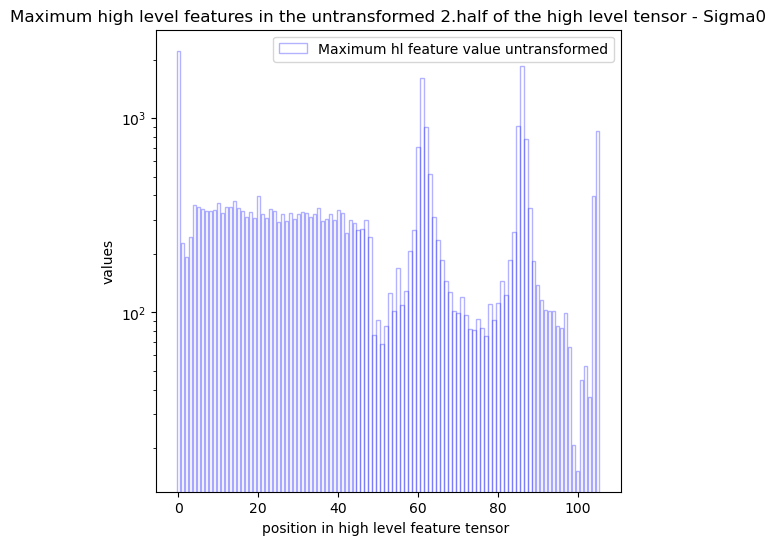

In [3]:
# Finding the maximum values of the each high level feature of the untransformed Dataset 

file_path_dict = {

    "file_path1" : '/beegfs/desy/user/schreibj/Hadron_classifier/shower_data/pion_510k_orig_merged.hdf5',
    "file_path2" : '/beegfs/desy/user/schreibj/Hadron_classifier/shower_data/pion_510k_trafo_0Sigma.hdf5',                  
    "file_path3" : '/beegfs/desy/user/schreibj/Hadron_classifier/shower_data/pion_510k_orig_validation.hdf5',
    "file_path4" : '/beegfs/desy/user/schreibj/Hadron_classifier/shower_data/pion_510k_trafo_0Sigma_validation.hdf5',               
    "file_path5" : '/beegfs/desy/user/schreibj/Hadron_classifier/shower_data/pion_510k_orig_test.hdf5',
    "file_path6" : '/beegfs/desy/user/schreibj/Hadron_classifier/shower_data/pion_510k_trafo_0Sigma_test.hdf5',                           

}
hl_feature_array_orig_0Sigma, hl_feature_array_trafo_0Sigma = loading_hl_features(file_path_dict)

print(hl_feature_array_orig_0Sigma.shape)
print(hl_feature_array_trafo_0Sigma.shape)

#Plotting the maximum value for each observable in the untransformed 2.half of the high level tensor
maximum_hl_features_untransformed_0Sigma = np.amax(hl_feature_array_trafo_0Sigma, axis = 0)

figOcc = plt.figure(figsize=(6,6))
axOcc = figOcc.add_subplot(1,1,1)

xmin = 0
xmax = 2000
nbins= 100

pOccb = axOcc.bar(np.arange(n_hl_features), height = maximum_hl_features_untransformed_0Sigma.flatten(), label = "Maximum hl feature value untransformed",  alpha=0.3,  color = 'none' ,  edgecolor = 'blue')

plt.xlabel('position in high level feature tensor ')
plt.ylabel('values')
plt.title('Maximum high level features in the untransformed 2.half of the high level tensor - Sigma0')
axOcc.legend()
axOcc.set_yscale('log')
plt.show()
#plt.savefig(f"/beegfs/desy/user/schreibj/Hadron_classifier/Savings_complete/v5_Wasserstein1D/maximum_mmd_scores_every_hl_feature_separately_untransformed_0Sigma_{str(datetime.now())}.pdf")


# 1,0 Sigma

self.spacings[     0.  51000. 102000. 153000. 204000. 255000.]
number of test batches: 19
batch_idx: 0
hl_feature_array_orig_1.shape: (1280, 106)
hl_feature_array_trafo_1.shape: (1280, 106)
hl_feature_array_orig_2.shape: (1280, 106)
hl_feature_array_trafo_2.shape: (1280, 106)
hl_feature_array_orig_3.shape: (1280, 106)
hl_feature_array_trafo_3.shape: (1280, 106)
hl_feature_array_orig_4.shape: (1280, 106)
hl_feature_array_trafo_4.shape: (1280, 106)
hl_feature_array_orig_5.shape: (1280, 106)
hl_feature_array_trafo_5.shape: (1280, 106)
batch_idx: 10
hl_feature_array_orig_1.shape: (14080, 106)
hl_feature_array_trafo_1.shape: (14080, 106)
hl_feature_array_orig_2.shape: (14080, 106)
hl_feature_array_trafo_2.shape: (14080, 106)
hl_feature_array_orig_3.shape: (14080, 106)
hl_feature_array_trafo_3.shape: (14080, 106)
hl_feature_array_orig_4.shape: (14080, 106)
hl_feature_array_trafo_4.shape: (14080, 106)
hl_feature_array_orig_5.shape: (14080, 106)
hl_feature_array_trafo_5.shape: (14080, 106)
bat

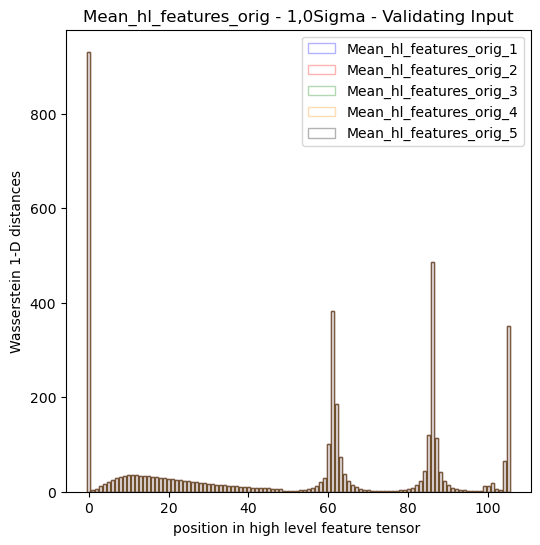

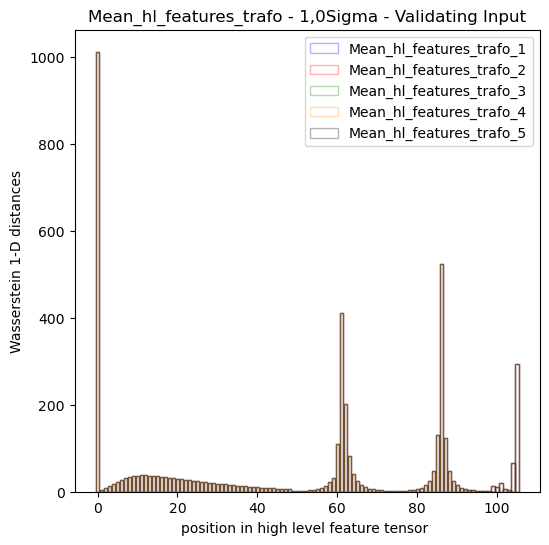

mmd_score_hl_features_normalized_1Sigma_1: 0.006996035575866699
mmd_score_hl_features_normalized_1Sigma_2: 0.007361888885498047
mmd_score_hl_features_normalized_1Sigma_3: 0.007268667221069336
mmd_score_hl_features_normalized_1Sigma_4: 0.007307291030883789
mmd_score_hl_features_normalized_1Sigma_5: 0.007202029228210449
Error Run mmd scores 1Sigma: 0.007227182388305664 +/- 0.0001267641563806193 - median: 0.007268667221069336
len(mean_mmd_scores_every_hl_feature_separately_normalized): 1
len(median_mmd_scores_every_hl_feature_separately_normalized): 1
len(std_mmd_scores_every_hl_feature_separately_normalized): 1
time for 5 models mmd scores: 0:01:58.655964


In [4]:
start = datetime.now()

file_path_dict = {

        "file_path1" : '/beegfs/desy/user/schreibj/Hadron_classifier/shower_data/pion_510k_orig_merged.hdf5',
        "file_path2" : '/beegfs/desy/user/schreibj/Hadron_classifier/shower_data/pion_510k_trafo_1,0Sigma_merged.hdf5',                      

}
    
hl_feature_array_orig_1Sigma_1, hl_feature_array_trafo_1Sigma_1, hl_feature_array_orig_1Sigma_2, hl_feature_array_trafo_1Sigma_2, hl_feature_array_orig_1Sigma_3, hl_feature_array_trafo_1Sigma_3, hl_feature_array_orig_1Sigma_4, hl_feature_array_trafo_1Sigma_4, hl_feature_array_orig_1Sigma_5, hl_feature_array_trafo_1Sigma_5 = loading_hl_features_five_models(file_path_dict)
print('----------------------------------------------------------------------------')
print(f'hl_feature_array_orig_1Sigma_1.shape: {hl_feature_array_orig_1Sigma_1.shape}')
print(f'hl_feature_array_trafo_1Sigma_1.shape: {hl_feature_array_trafo_1Sigma_1.shape}')
print(f'hl_feature_array_orig_1Sigma_2.shape: {hl_feature_array_orig_1Sigma_2.shape}')
print(f'hl_feature_array_trafo_1Sigma_2.shape: {hl_feature_array_trafo_1Sigma_2.shape}')
print(f'hl_feature_array_orig_1Sigma_3.shape: {hl_feature_array_orig_1Sigma_3.shape}')
print(f'hl_feature_array_trafo_1Sigma_3.shape: {hl_feature_array_trafo_1Sigma_3.shape}')
print(f'hl_feature_array_orig_1Sigma_4.shape: {hl_feature_array_orig_1Sigma_4.shape}')
print(f'hl_feature_array_trafo_1Sigma_4.shape: {hl_feature_array_trafo_1Sigma_4.shape}')
print(f'hl_feature_array_orig_1Sigma_5.shape: {hl_feature_array_orig_1Sigma_5.shape}')
print(f'hl_feature_array_trafo_1Sigma_5.shape: {hl_feature_array_trafo_1Sigma_5.shape}')



mean_hl_features_orig_1Sigma_1 = np.mean(hl_feature_array_orig_1Sigma_1, axis = 0)
mean_hl_features_orig_1Sigma_2 = np.mean(hl_feature_array_orig_1Sigma_1, axis = 0)
mean_hl_features_orig_1Sigma_3 = np.mean(hl_feature_array_orig_1Sigma_1, axis = 0)
mean_hl_features_orig_1Sigma_4 = np.mean(hl_feature_array_orig_1Sigma_1, axis = 0)
mean_hl_features_orig_1Sigma_5 = np.mean(hl_feature_array_orig_1Sigma_1, axis = 0)

figOcc = plt.figure(figsize=(6,6))
axOcc = figOcc.add_subplot(1,1,1)

xmin = 0
xmax = 2000
nbins= 100

pOcc1 = axOcc.bar(np.arange(n_hl_features), height = mean_hl_features_orig_1Sigma_1.flatten(), label = "Mean_hl_features_orig_1",  alpha=0.3,  color = 'none' ,  edgecolor = 'blue')
pOcc2 = axOcc.bar(np.arange(n_hl_features), height = mean_hl_features_orig_1Sigma_2.flatten(), label = "Mean_hl_features_orig_2",  alpha=0.3,  color = 'none' ,  edgecolor = 'red')
pOcc3 = axOcc.bar(np.arange(n_hl_features), height = mean_hl_features_orig_1Sigma_3.flatten(), label = "Mean_hl_features_orig_3",  alpha=0.3,  color = 'none' ,  edgecolor = 'green')
pOcc4 = axOcc.bar(np.arange(n_hl_features), height = mean_hl_features_orig_1Sigma_4.flatten(), label = "Mean_hl_features_orig_4",  alpha=0.3,  color = 'none' ,  edgecolor = 'darkorange')
pOcc5 = axOcc.bar(np.arange(n_hl_features), height = mean_hl_features_orig_1Sigma_5.flatten(), label = "Mean_hl_features_orig_5",  alpha=0.3,  color = 'none' ,  edgecolor = 'black')

plt.xlabel('position in high level feature tensor ')
plt.ylabel('Wasserstein 1-D distances')
plt.title('Mean_hl_features_orig - 1,0Sigma - Validating Input')
axOcc.legend()
#axOcc.set_yscale('log')
plt.show()
#plt.savefig(f"/beegfs/desy/user/schreibj/Hadron_classifier/Savings_complete/v5_Wasserstein1D/mmd_scores_every_hl_feature_separately_normalized_1Sigma_{str(datetime.now())}.pdf")






mean_hl_features_trafo_1Sigma_1 = np.mean(hl_feature_array_trafo_1Sigma_1, axis = 0)
mean_hl_features_trafo_1Sigma_2 = np.mean(hl_feature_array_trafo_1Sigma_1, axis = 0)
mean_hl_features_trafo_1Sigma_3 = np.mean(hl_feature_array_trafo_1Sigma_1, axis = 0)
mean_hl_features_trafo_1Sigma_4 = np.mean(hl_feature_array_trafo_1Sigma_1, axis = 0)
mean_hl_features_trafo_1Sigma_5 = np.mean(hl_feature_array_trafo_1Sigma_1, axis = 0)

figOcc = plt.figure(figsize=(6,6))
axOcc = figOcc.add_subplot(1,1,1)

xmin = 0
xmax = 2000
nbins= 100

pOcc1 = axOcc.bar(np.arange(n_hl_features), height = mean_hl_features_trafo_1Sigma_1.flatten(), label = "Mean_hl_features_trafo_1",  alpha=0.3,  color = 'none' ,  edgecolor = 'blue')
pOcc2 = axOcc.bar(np.arange(n_hl_features), height = mean_hl_features_trafo_1Sigma_2.flatten(), label = "Mean_hl_features_trafo_2",  alpha=0.3,  color = 'none' ,  edgecolor = 'red')
pOcc3 = axOcc.bar(np.arange(n_hl_features), height = mean_hl_features_trafo_1Sigma_3.flatten(), label = "Mean_hl_features_trafo_3",  alpha=0.3,  color = 'none' ,  edgecolor = 'green')
pOcc4 = axOcc.bar(np.arange(n_hl_features), height = mean_hl_features_trafo_1Sigma_4.flatten(), label = "Mean_hl_features_trafo_4",  alpha=0.3,  color = 'none' ,  edgecolor = 'darkorange')
pOcc5 = axOcc.bar(np.arange(n_hl_features), height = mean_hl_features_trafo_1Sigma_5.flatten(), label = "Mean_hl_features_trafo_5",  alpha=0.3,  color = 'none' ,  edgecolor = 'black')

plt.xlabel('position in high level feature tensor ')
plt.ylabel('Wasserstein 1-D distances')
plt.title('Mean_hl_features_trafo - 1,0Sigma - Validating Input')
axOcc.legend()
#axOcc.set_yscale('log')
plt.show()
#plt.savefig(f"/beegfs/desy/user/schreibj/Hadron_classifier/Savings_complete/v5_Wasserstein1D/mmd_scores_every_hl_feature_separately_normalized_1Sigma_{str(datetime.now())}.pdf")


hl_feature_array_orig_1Sigma_normalized_1  = hl_feature_array_orig_1Sigma_1/maximum_hl_features_untransformed_0Sigma
hl_feature_array_trafo_1Sigma_normalized_1 = hl_feature_array_trafo_1Sigma_1/maximum_hl_features_untransformed_0Sigma
hl_feature_array_orig_1Sigma_normalized_2  = hl_feature_array_orig_1Sigma_2/maximum_hl_features_untransformed_0Sigma
hl_feature_array_trafo_1Sigma_normalized_2 = hl_feature_array_trafo_1Sigma_2/maximum_hl_features_untransformed_0Sigma
hl_feature_array_orig_1Sigma_normalized_3  = hl_feature_array_orig_1Sigma_3/maximum_hl_features_untransformed_0Sigma
hl_feature_array_trafo_1Sigma_normalized_3 = hl_feature_array_trafo_1Sigma_3/maximum_hl_features_untransformed_0Sigma
hl_feature_array_orig_1Sigma_normalized_4  = hl_feature_array_orig_1Sigma_4/maximum_hl_features_untransformed_0Sigma
hl_feature_array_trafo_1Sigma_normalized_4 = hl_feature_array_trafo_1Sigma_4/maximum_hl_features_untransformed_0Sigma
hl_feature_array_orig_1Sigma_normalized_5  = hl_feature_array_orig_1Sigma_5/maximum_hl_features_untransformed_0Sigma
hl_feature_array_trafo_1Sigma_normalized_5 = hl_feature_array_trafo_1Sigma_5/maximum_hl_features_untransformed_0Sigma


mmd_score_hl_features_normalized_1Sigma_1 = energy_distance_mmd(torch.from_numpy(hl_feature_array_orig_1Sigma_normalized_1), torch.from_numpy(hl_feature_array_trafo_1Sigma_normalized_1)).item()
print(f'mmd_score_hl_features_normalized_1Sigma_1: {mmd_score_hl_features_normalized_1Sigma_1}')
mmd_score_hl_features_normalized_1Sigma_2 = energy_distance_mmd(torch.from_numpy(hl_feature_array_orig_1Sigma_normalized_2), torch.from_numpy(hl_feature_array_trafo_1Sigma_normalized_2)).item()
print(f'mmd_score_hl_features_normalized_1Sigma_2: {mmd_score_hl_features_normalized_1Sigma_2}')
mmd_score_hl_features_normalized_1Sigma_3 = energy_distance_mmd(torch.from_numpy(hl_feature_array_orig_1Sigma_normalized_3), torch.from_numpy(hl_feature_array_trafo_1Sigma_normalized_3)).item()
print(f'mmd_score_hl_features_normalized_1Sigma_3: {mmd_score_hl_features_normalized_1Sigma_3}')
mmd_score_hl_features_normalized_1Sigma_4 = energy_distance_mmd(torch.from_numpy(hl_feature_array_orig_1Sigma_normalized_4), torch.from_numpy(hl_feature_array_trafo_1Sigma_normalized_4)).item()
print(f'mmd_score_hl_features_normalized_1Sigma_4: {mmd_score_hl_features_normalized_1Sigma_4}')
mmd_score_hl_features_normalized_1Sigma_5 = energy_distance_mmd(torch.from_numpy(hl_feature_array_orig_1Sigma_normalized_5), torch.from_numpy(hl_feature_array_trafo_1Sigma_normalized_5)).item()
print(f'mmd_score_hl_features_normalized_1Sigma_5: {mmd_score_hl_features_normalized_1Sigma_5}')






mmd_scores_1Sigma_five_models = np.array([])

mmd_scores_1Sigma_five_models = np.append(mmd_scores_1Sigma_five_models,mmd_score_hl_features_normalized_1Sigma_1)
mmd_scores_1Sigma_five_models = np.append(mmd_scores_1Sigma_five_models,mmd_score_hl_features_normalized_1Sigma_2)
mmd_scores_1Sigma_five_models = np.append(mmd_scores_1Sigma_five_models,mmd_score_hl_features_normalized_1Sigma_3)
mmd_scores_1Sigma_five_models = np.append(mmd_scores_1Sigma_five_models,mmd_score_hl_features_normalized_1Sigma_4)
mmd_scores_1Sigma_five_models = np.append(mmd_scores_1Sigma_five_models,mmd_score_hl_features_normalized_1Sigma_5)

max_mmd_scores_every_hl_feature_separately_normalized.append(np.abs( np.median(mmd_scores_1Sigma_five_models) - np.max(mmd_scores_1Sigma_five_models) ))
min_mmd_scores_every_hl_feature_separately_normalized.append(np.abs( np.median(mmd_scores_1Sigma_five_models) - np.min(mmd_scores_1Sigma_five_models) ))
print(f'Error Run mmd scores 1Sigma: {np.mean(mmd_scores_1Sigma_five_models)} +/- {np.std(mmd_scores_1Sigma_five_models)} - median: {np.median(mmd_scores_1Sigma_five_models)}')
mean_mmd_scores_every_hl_feature_separately_normalized.append(np.mean(mmd_scores_1Sigma_five_models))
print(f'len(mean_mmd_scores_every_hl_feature_separately_normalized): {len(mean_mmd_scores_every_hl_feature_separately_normalized)}')
median_mmd_scores_every_hl_feature_separately_normalized.append(np.median(mmd_scores_1Sigma_five_models))
print(f'len(median_mmd_scores_every_hl_feature_separately_normalized): {len(median_mmd_scores_every_hl_feature_separately_normalized)}')
std_mmd_scores_every_hl_feature_separately_normalized.append(np.std(mmd_scores_1Sigma_five_models))
print(f'len(std_mmd_scores_every_hl_feature_separately_normalized): {len(std_mmd_scores_every_hl_feature_separately_normalized)}')



end = datetime.now()

print(f'time for 5 models mmd scores: {end - start}')

# 0,75 Sigma 

In [5]:

file_path_dict = {

        "file_path1" : '/beegfs/desy/user/schreibj/Hadron_classifier/shower_data/pion_510k_orig_merged.hdf5',
        "file_path2" : '/beegfs/desy/user/schreibj/Hadron_classifier/shower_data/pion_510k_trafo_0,75Sigma_merged.hdf5',                                              

}
    
hl_feature_array_orig_075Sigma_1, hl_feature_array_trafo_075Sigma_1, hl_feature_array_orig_075Sigma_2, hl_feature_array_trafo_075Sigma_2, hl_feature_array_orig_075Sigma_3, hl_feature_array_trafo_075Sigma_3, hl_feature_array_orig_075Sigma_4, hl_feature_array_trafo_075Sigma_4, hl_feature_array_orig_075Sigma_5, hl_feature_array_trafo_075Sigma_5 = loading_hl_features_five_models(file_path_dict)
print('----------------------------------------------------------------------------')
print(f'hl_feature_array_orig_075Sigma_1.shape: {hl_feature_array_orig_075Sigma_1.shape}')
print(f'hl_feature_array_trafo_075Sigma_1.shape: {hl_feature_array_trafo_075Sigma_1.shape}')
print(f'hl_feature_array_orig_075Sigma_2.shape: {hl_feature_array_orig_075Sigma_2.shape}')
print(f'hl_feature_array_trafo_075Sigma_2.shape: {hl_feature_array_trafo_075Sigma_2.shape}')
print(f'hl_feature_array_orig_075Sigma_3.shape: {hl_feature_array_orig_075Sigma_3.shape}')
print(f'hl_feature_array_trafo_075Sigma_3.shape: {hl_feature_array_trafo_075Sigma_3.shape}')
print(f'hl_feature_array_orig_075Sigma_4.shape: {hl_feature_array_orig_075Sigma_4.shape}')
print(f'hl_feature_array_trafo_075Sigma_4.shape: {hl_feature_array_trafo_075Sigma_4.shape}')
print(f'hl_feature_array_orig_075Sigma_5.shape: {hl_feature_array_orig_075Sigma_5.shape}')
print(f'hl_feature_array_trafo_075Sigma_5.shape: {hl_feature_array_trafo_075Sigma_5.shape}')


start = datetime.now()

hl_feature_array_orig_075Sigma_normalized_1  = hl_feature_array_orig_075Sigma_1/maximum_hl_features_untransformed_0Sigma
hl_feature_array_trafo_075Sigma_normalized_1 = hl_feature_array_trafo_075Sigma_1/maximum_hl_features_untransformed_0Sigma
hl_feature_array_orig_075Sigma_normalized_2  = hl_feature_array_orig_075Sigma_2/maximum_hl_features_untransformed_0Sigma
hl_feature_array_trafo_075Sigma_normalized_2 = hl_feature_array_trafo_075Sigma_2/maximum_hl_features_untransformed_0Sigma
hl_feature_array_orig_075Sigma_normalized_3  = hl_feature_array_orig_075Sigma_3/maximum_hl_features_untransformed_0Sigma
hl_feature_array_trafo_075Sigma_normalized_3 = hl_feature_array_trafo_075Sigma_3/maximum_hl_features_untransformed_0Sigma
hl_feature_array_orig_075Sigma_normalized_4  = hl_feature_array_orig_075Sigma_4/maximum_hl_features_untransformed_0Sigma
hl_feature_array_trafo_075Sigma_normalized_4 = hl_feature_array_trafo_075Sigma_4/maximum_hl_features_untransformed_0Sigma
hl_feature_array_orig_075Sigma_normalized_5  = hl_feature_array_orig_075Sigma_5/maximum_hl_features_untransformed_0Sigma
hl_feature_array_trafo_075Sigma_normalized_5 = hl_feature_array_trafo_075Sigma_5/maximum_hl_features_untransformed_0Sigma

mmd_score_hl_features_normalized_075Sigma_1 = energy_distance_mmd(torch.from_numpy(hl_feature_array_orig_075Sigma_normalized_1), torch.from_numpy(hl_feature_array_trafo_075Sigma_normalized_1)).item()
print(f'mmd_score_hl_features_normalized_075Sigma_1: {mmd_score_hl_features_normalized_075Sigma_1}')
mmd_score_hl_features_normalized_075Sigma_2 = energy_distance_mmd(torch.from_numpy(hl_feature_array_orig_075Sigma_normalized_2), torch.from_numpy(hl_feature_array_trafo_075Sigma_normalized_2)).item()
print(f'mmd_score_hl_features_normalized_075Sigma_2: {mmd_score_hl_features_normalized_075Sigma_2}')
mmd_score_hl_features_normalized_075Sigma_3 = energy_distance_mmd(torch.from_numpy(hl_feature_array_orig_075Sigma_normalized_3), torch.from_numpy(hl_feature_array_trafo_075Sigma_normalized_3)).item()
print(f'mmd_score_hl_features_normalized_075Sigma_3: {mmd_score_hl_features_normalized_075Sigma_3}')
mmd_score_hl_features_normalized_075Sigma_4 = energy_distance_mmd(torch.from_numpy(hl_feature_array_orig_075Sigma_normalized_4), torch.from_numpy(hl_feature_array_trafo_075Sigma_normalized_4)).item()
print(f'mmd_score_hl_features_normalized_075Sigma_4: {mmd_score_hl_features_normalized_075Sigma_4}')
mmd_score_hl_features_normalized_075Sigma_5 = energy_distance_mmd(torch.from_numpy(hl_feature_array_orig_075Sigma_normalized_5), torch.from_numpy(hl_feature_array_trafo_075Sigma_normalized_5)).item()
print(f'mmd_score_hl_features_normalized_075Sigma_5: {mmd_score_hl_features_normalized_075Sigma_5}')



mmd_scores_075Sigma_five_models = np.array([])

mmd_scores_075Sigma_five_models = np.append(mmd_scores_075Sigma_five_models,mmd_score_hl_features_normalized_075Sigma_1)
mmd_scores_075Sigma_five_models = np.append(mmd_scores_075Sigma_five_models,mmd_score_hl_features_normalized_075Sigma_2)
mmd_scores_075Sigma_five_models = np.append(mmd_scores_075Sigma_five_models,mmd_score_hl_features_normalized_075Sigma_3)
mmd_scores_075Sigma_five_models = np.append(mmd_scores_075Sigma_five_models,mmd_score_hl_features_normalized_075Sigma_4)
mmd_scores_075Sigma_five_models = np.append(mmd_scores_075Sigma_five_models,mmd_score_hl_features_normalized_075Sigma_5)

max_mmd_scores_every_hl_feature_separately_normalized.append(np.abs( np.median(mmd_scores_075Sigma_five_models) - np.max(mmd_scores_075Sigma_five_models) ))
min_mmd_scores_every_hl_feature_separately_normalized.append(np.abs( np.median(mmd_scores_075Sigma_five_models) - np.min(mmd_scores_075Sigma_five_models) ))
print(f'Error Run mmd scores 075Sigma: {np.mean(mmd_scores_075Sigma_five_models)} +/- {np.std(mmd_scores_075Sigma_five_models)} - median: {np.median(mmd_scores_075Sigma_five_models)}')
mean_mmd_scores_every_hl_feature_separately_normalized.append(np.mean(mmd_scores_075Sigma_five_models))
print(f'len(mean_mmd_scores_every_hl_feature_separately_normalized): {len(mean_mmd_scores_every_hl_feature_separately_normalized)}')
median_mmd_scores_every_hl_feature_separately_normalized.append(np.median(mmd_scores_075Sigma_five_models))
print(f'len(median_mmd_scores_every_hl_feature_separately_normalized): {len(median_mmd_scores_every_hl_feature_separately_normalized)}')
std_mmd_scores_every_hl_feature_separately_normalized.append(np.std(mmd_scores_075Sigma_five_models))
print(f'len(std_mmd_scores_every_hl_feature_separately_normalized): {len(std_mmd_scores_every_hl_feature_separately_normalized)}')

end = datetime.now()

print(f'time for 5 models mmd scores: {end - start}')

self.spacings[     0.  51000. 102000. 153000. 204000. 255000.]
number of test batches: 19
batch_idx: 0
hl_feature_array_orig_1.shape: (1280, 106)
hl_feature_array_trafo_1.shape: (1280, 106)
hl_feature_array_orig_2.shape: (1280, 106)
hl_feature_array_trafo_2.shape: (1280, 106)
hl_feature_array_orig_3.shape: (1280, 106)
hl_feature_array_trafo_3.shape: (1280, 106)
hl_feature_array_orig_4.shape: (1280, 106)
hl_feature_array_trafo_4.shape: (1280, 106)
hl_feature_array_orig_5.shape: (1280, 106)
hl_feature_array_trafo_5.shape: (1280, 106)
batch_idx: 10
hl_feature_array_orig_1.shape: (14080, 106)
hl_feature_array_trafo_1.shape: (14080, 106)
hl_feature_array_orig_2.shape: (14080, 106)
hl_feature_array_trafo_2.shape: (14080, 106)
hl_feature_array_orig_3.shape: (14080, 106)
hl_feature_array_trafo_3.shape: (14080, 106)
hl_feature_array_orig_4.shape: (14080, 106)
hl_feature_array_trafo_4.shape: (14080, 106)
hl_feature_array_orig_5.shape: (14080, 106)
hl_feature_array_trafo_5.shape: (14080, 106)
bat

# 0,5 Sigma 

In [6]:

file_path_dict = {

        "file_path1" : '/beegfs/desy/user/schreibj/Hadron_classifier/shower_data/pion_510k_orig_merged.hdf5',
        "file_path2" : '/beegfs/desy/user/schreibj/Hadron_classifier/shower_data/pion_510k_trafo_0,5Sigma_merged.hdf5',                                              

}
    
hl_feature_array_orig_05Sigma_1, hl_feature_array_trafo_05Sigma_1, hl_feature_array_orig_05Sigma_2, hl_feature_array_trafo_05Sigma_2, hl_feature_array_orig_05Sigma_3, hl_feature_array_trafo_05Sigma_3, hl_feature_array_orig_05Sigma_4, hl_feature_array_trafo_05Sigma_4, hl_feature_array_orig_05Sigma_5, hl_feature_array_trafo_05Sigma_5 = loading_hl_features_five_models(file_path_dict)
print('----------------------------------------------------------------------------')
print(f'hl_feature_array_orig_05Sigma_1.shape: {hl_feature_array_orig_05Sigma_1.shape}')
print(f'hl_feature_array_trafo_05Sigma_1.shape: {hl_feature_array_trafo_05Sigma_1.shape}')
print(f'hl_feature_array_orig_05Sigma_2.shape: {hl_feature_array_orig_05Sigma_2.shape}')
print(f'hl_feature_array_trafo_05Sigma_2.shape: {hl_feature_array_trafo_05Sigma_2.shape}')
print(f'hl_feature_array_orig_05Sigma_3.shape: {hl_feature_array_orig_05Sigma_3.shape}')
print(f'hl_feature_array_trafo_05Sigma_3.shape: {hl_feature_array_trafo_05Sigma_3.shape}')
print(f'hl_feature_array_orig_05Sigma_4.shape: {hl_feature_array_orig_05Sigma_4.shape}')
print(f'hl_feature_array_trafo_05Sigma_4.shape: {hl_feature_array_trafo_05Sigma_4.shape}')
print(f'hl_feature_array_orig_05Sigma_5.shape: {hl_feature_array_orig_05Sigma_5.shape}')
print(f'hl_feature_array_trafo_05Sigma_5.shape: {hl_feature_array_trafo_05Sigma_5.shape}')


hl_feature_array_orig_05Sigma_normalized_1  = hl_feature_array_orig_05Sigma_1/maximum_hl_features_untransformed_0Sigma
hl_feature_array_trafo_05Sigma_normalized_1 = hl_feature_array_trafo_05Sigma_1/maximum_hl_features_untransformed_0Sigma
hl_feature_array_orig_05Sigma_normalized_2  = hl_feature_array_orig_05Sigma_2/maximum_hl_features_untransformed_0Sigma
hl_feature_array_trafo_05Sigma_normalized_2 = hl_feature_array_trafo_05Sigma_2/maximum_hl_features_untransformed_0Sigma
hl_feature_array_orig_05Sigma_normalized_3  = hl_feature_array_orig_05Sigma_3/maximum_hl_features_untransformed_0Sigma
hl_feature_array_trafo_05Sigma_normalized_3 = hl_feature_array_trafo_05Sigma_3/maximum_hl_features_untransformed_0Sigma
hl_feature_array_orig_05Sigma_normalized_4  = hl_feature_array_orig_05Sigma_4/maximum_hl_features_untransformed_0Sigma
hl_feature_array_trafo_05Sigma_normalized_4 = hl_feature_array_trafo_05Sigma_4/maximum_hl_features_untransformed_0Sigma
hl_feature_array_orig_05Sigma_normalized_5  = hl_feature_array_orig_05Sigma_5/maximum_hl_features_untransformed_0Sigma
hl_feature_array_trafo_05Sigma_normalized_5 = hl_feature_array_trafo_05Sigma_5/maximum_hl_features_untransformed_0Sigma

mmd_score_hl_features_normalized_05Sigma_1 = energy_distance_mmd(torch.from_numpy(hl_feature_array_orig_05Sigma_normalized_1), torch.from_numpy(hl_feature_array_trafo_05Sigma_normalized_1)).item()
print(f'mmd_score_hl_features_normalized_05Sigma_1: {mmd_score_hl_features_normalized_05Sigma_1}')
mmd_score_hl_features_normalized_05Sigma_2 = energy_distance_mmd(torch.from_numpy(hl_feature_array_orig_05Sigma_normalized_2), torch.from_numpy(hl_feature_array_trafo_05Sigma_normalized_2)).item()
print(f'mmd_score_hl_features_normalized_05Sigma_2: {mmd_score_hl_features_normalized_05Sigma_2}')
mmd_score_hl_features_normalized_05Sigma_3 = energy_distance_mmd(torch.from_numpy(hl_feature_array_orig_05Sigma_normalized_3), torch.from_numpy(hl_feature_array_trafo_05Sigma_normalized_3)).item()
print(f'mmd_score_hl_features_normalized_05Sigma_3: {mmd_score_hl_features_normalized_05Sigma_3}')
mmd_score_hl_features_normalized_05Sigma_4 = energy_distance_mmd(torch.from_numpy(hl_feature_array_orig_05Sigma_normalized_4), torch.from_numpy(hl_feature_array_trafo_05Sigma_normalized_4)).item()
print(f'mmd_score_hl_features_normalized_05Sigma_4: {mmd_score_hl_features_normalized_05Sigma_4}')
mmd_score_hl_features_normalized_05Sigma_5 = energy_distance_mmd(torch.from_numpy(hl_feature_array_orig_05Sigma_normalized_5), torch.from_numpy(hl_feature_array_trafo_05Sigma_normalized_5)).item()
print(f'mmd_score_hl_features_normalized_05Sigma_5: {mmd_score_hl_features_normalized_05Sigma_5}')


print(f'mmd_score_hl_features_normalized_05Sigma_1: {mmd_score_hl_features_normalized_05Sigma_1}')
print(f'mmd_score_hl_features_normalized_05Sigma_2: {mmd_score_hl_features_normalized_05Sigma_2}')
print(f'mmd_score_hl_features_normalized_05Sigma_3: {mmd_score_hl_features_normalized_05Sigma_3}')
print(f'mmd_score_hl_features_normalized_05Sigma_4: {mmd_score_hl_features_normalized_05Sigma_4}')
print(f'mmd_score_hl_features_normalized_05Sigma_5: {mmd_score_hl_features_normalized_05Sigma_5}')


mmd_scores_05Sigma_five_models = np.array([])

mmd_scores_05Sigma_five_models = np.append(mmd_scores_05Sigma_five_models,mmd_score_hl_features_normalized_05Sigma_1)
mmd_scores_05Sigma_five_models = np.append(mmd_scores_05Sigma_five_models,mmd_score_hl_features_normalized_05Sigma_2)
mmd_scores_05Sigma_five_models = np.append(mmd_scores_05Sigma_five_models,mmd_score_hl_features_normalized_05Sigma_3)
mmd_scores_05Sigma_five_models = np.append(mmd_scores_05Sigma_five_models,mmd_score_hl_features_normalized_05Sigma_4)
mmd_scores_05Sigma_five_models = np.append(mmd_scores_05Sigma_five_models,mmd_score_hl_features_normalized_05Sigma_5)

max_mmd_scores_every_hl_feature_separately_normalized.append(np.abs( np.median(mmd_scores_05Sigma_five_models) - np.max(mmd_scores_05Sigma_five_models) ))
min_mmd_scores_every_hl_feature_separately_normalized.append(np.abs( np.median(mmd_scores_05Sigma_five_models) - np.min(mmd_scores_05Sigma_five_models) ))
print(f'Error Run mmd scores 05Sigma: {np.mean(mmd_scores_05Sigma_five_models)} +/- {np.std(mmd_scores_05Sigma_five_models)} - median: {np.median(mmd_scores_05Sigma_five_models)}')
mean_mmd_scores_every_hl_feature_separately_normalized.append(np.mean(mmd_scores_05Sigma_five_models))
print(f'len(mean_mmd_scores_every_hl_feature_separately_normalized): {len(mean_mmd_scores_every_hl_feature_separately_normalized)}')
median_mmd_scores_every_hl_feature_separately_normalized.append(np.median(mmd_scores_05Sigma_five_models))
print(f'len(median_mmd_scores_every_hl_feature_separately_normalized): {len(median_mmd_scores_every_hl_feature_separately_normalized)}')
std_mmd_scores_every_hl_feature_separately_normalized.append(np.std(mmd_scores_05Sigma_five_models))
print(f'len(std_mmd_scores_every_hl_feature_separately_normalized): {len(std_mmd_scores_every_hl_feature_separately_normalized)}')


end = datetime.now()

print(f'time for 5 models mmd scores: {end - start}')

self.spacings[     0.  51000. 102000. 153000. 204000. 255000.]
number of test batches: 19
batch_idx: 0
hl_feature_array_orig_1.shape: (1280, 106)
hl_feature_array_trafo_1.shape: (1280, 106)
hl_feature_array_orig_2.shape: (1280, 106)
hl_feature_array_trafo_2.shape: (1280, 106)
hl_feature_array_orig_3.shape: (1280, 106)
hl_feature_array_trafo_3.shape: (1280, 106)
hl_feature_array_orig_4.shape: (1280, 106)
hl_feature_array_trafo_4.shape: (1280, 106)
hl_feature_array_orig_5.shape: (1280, 106)
hl_feature_array_trafo_5.shape: (1280, 106)
batch_idx: 10
hl_feature_array_orig_1.shape: (14080, 106)
hl_feature_array_trafo_1.shape: (14080, 106)
hl_feature_array_orig_2.shape: (14080, 106)
hl_feature_array_trafo_2.shape: (14080, 106)
hl_feature_array_orig_3.shape: (14080, 106)
hl_feature_array_trafo_3.shape: (14080, 106)
hl_feature_array_orig_4.shape: (14080, 106)
hl_feature_array_trafo_4.shape: (14080, 106)
hl_feature_array_orig_5.shape: (14080, 106)
hl_feature_array_trafo_5.shape: (14080, 106)
bat

# 0,25 Sigma

In [7]:

file_path_dict = {

        "file_path1" : '/beegfs/desy/user/schreibj/Hadron_classifier/shower_data/pion_510k_orig_merged.hdf5',
        "file_path2" : '/beegfs/desy/user/schreibj/Hadron_classifier/shower_data/pion_510k_trafo_0,25Sigma_merged.hdf5',                                              

}
    
hl_feature_array_orig_025Sigma_1, hl_feature_array_trafo_025Sigma_1, hl_feature_array_orig_025Sigma_2, hl_feature_array_trafo_025Sigma_2, hl_feature_array_orig_025Sigma_3, hl_feature_array_trafo_025Sigma_3, hl_feature_array_orig_025Sigma_4, hl_feature_array_trafo_025Sigma_4, hl_feature_array_orig_025Sigma_5, hl_feature_array_trafo_025Sigma_5 = loading_hl_features_five_models(file_path_dict)
print('----------------------------------------------------------------------------')
print(f'hl_feature_array_orig_025Sigma_1.shape: {hl_feature_array_orig_025Sigma_1.shape}')
print(f'hl_feature_array_trafo_025Sigma_1.shape: {hl_feature_array_trafo_025Sigma_1.shape}')
print(f'hl_feature_array_orig_025Sigma_2.shape: {hl_feature_array_orig_025Sigma_2.shape}')
print(f'hl_feature_array_trafo_025Sigma_2.shape: {hl_feature_array_trafo_025Sigma_2.shape}')
print(f'hl_feature_array_orig_025Sigma_3.shape: {hl_feature_array_orig_025Sigma_3.shape}')
print(f'hl_feature_array_trafo_025Sigma_3.shape: {hl_feature_array_trafo_025Sigma_3.shape}')
print(f'hl_feature_array_orig_025Sigma_4.shape: {hl_feature_array_orig_025Sigma_4.shape}')
print(f'hl_feature_array_trafo_025Sigma_4.shape: {hl_feature_array_trafo_025Sigma_4.shape}')
print(f'hl_feature_array_orig_025Sigma_5.shape: {hl_feature_array_orig_025Sigma_5.shape}')
print(f'hl_feature_array_trafo_025Sigma_5.shape: {hl_feature_array_trafo_025Sigma_5.shape}')


hl_feature_array_orig_025Sigma_normalized_1  = hl_feature_array_orig_025Sigma_1/maximum_hl_features_untransformed_0Sigma
hl_feature_array_trafo_025Sigma_normalized_1 = hl_feature_array_trafo_025Sigma_1/maximum_hl_features_untransformed_0Sigma
hl_feature_array_orig_025Sigma_normalized_2  = hl_feature_array_orig_025Sigma_2/maximum_hl_features_untransformed_0Sigma
hl_feature_array_trafo_025Sigma_normalized_2 = hl_feature_array_trafo_025Sigma_2/maximum_hl_features_untransformed_0Sigma
hl_feature_array_orig_025Sigma_normalized_3  = hl_feature_array_orig_025Sigma_3/maximum_hl_features_untransformed_0Sigma
hl_feature_array_trafo_025Sigma_normalized_3 = hl_feature_array_trafo_025Sigma_3/maximum_hl_features_untransformed_0Sigma
hl_feature_array_orig_025Sigma_normalized_4  = hl_feature_array_orig_025Sigma_4/maximum_hl_features_untransformed_0Sigma
hl_feature_array_trafo_025Sigma_normalized_4 = hl_feature_array_trafo_025Sigma_4/maximum_hl_features_untransformed_0Sigma
hl_feature_array_orig_025Sigma_normalized_5  = hl_feature_array_orig_025Sigma_5/maximum_hl_features_untransformed_0Sigma
hl_feature_array_trafo_025Sigma_normalized_5 = hl_feature_array_trafo_025Sigma_5/maximum_hl_features_untransformed_0Sigma

mmd_score_hl_features_normalized_025Sigma_1 = energy_distance_mmd(torch.from_numpy(hl_feature_array_orig_025Sigma_normalized_1), torch.from_numpy(hl_feature_array_trafo_025Sigma_normalized_1)).item()
print(f'mmd_score_hl_features_normalized_025Sigma_1: {mmd_score_hl_features_normalized_025Sigma_1}')
mmd_score_hl_features_normalized_025Sigma_2 = energy_distance_mmd(torch.from_numpy(hl_feature_array_orig_025Sigma_normalized_2), torch.from_numpy(hl_feature_array_trafo_025Sigma_normalized_2)).item()
print(f'mmd_score_hl_features_normalized_025Sigma_2: {mmd_score_hl_features_normalized_025Sigma_2}')
mmd_score_hl_features_normalized_025Sigma_3 = energy_distance_mmd(torch.from_numpy(hl_feature_array_orig_025Sigma_normalized_3), torch.from_numpy(hl_feature_array_trafo_025Sigma_normalized_3)).item()
print(f'mmd_score_hl_features_normalized_025Sigma_3: {mmd_score_hl_features_normalized_025Sigma_3}')
mmd_score_hl_features_normalized_025Sigma_4 = energy_distance_mmd(torch.from_numpy(hl_feature_array_orig_025Sigma_normalized_4), torch.from_numpy(hl_feature_array_trafo_025Sigma_normalized_4)).item()
print(f'mmd_score_hl_features_normalized_025Sigma_4: {mmd_score_hl_features_normalized_025Sigma_4}')
mmd_score_hl_features_normalized_025Sigma_5 = energy_distance_mmd(torch.from_numpy(hl_feature_array_orig_025Sigma_normalized_5), torch.from_numpy(hl_feature_array_trafo_025Sigma_normalized_5)).item()
print(f'mmd_score_hl_features_normalized_025Sigma_5: {mmd_score_hl_features_normalized_025Sigma_5}')


mmd_scores_025Sigma_five_models = np.array([])

mmd_scores_025Sigma_five_models = np.append(mmd_scores_025Sigma_five_models,mmd_score_hl_features_normalized_025Sigma_1)
mmd_scores_025Sigma_five_models = np.append(mmd_scores_025Sigma_five_models,mmd_score_hl_features_normalized_025Sigma_2)
mmd_scores_025Sigma_five_models = np.append(mmd_scores_025Sigma_five_models,mmd_score_hl_features_normalized_025Sigma_3)
mmd_scores_025Sigma_five_models = np.append(mmd_scores_025Sigma_five_models,mmd_score_hl_features_normalized_025Sigma_4)
mmd_scores_025Sigma_five_models = np.append(mmd_scores_025Sigma_five_models,mmd_score_hl_features_normalized_025Sigma_5)

max_mmd_scores_every_hl_feature_separately_normalized.append(np.abs( np.median(mmd_scores_025Sigma_five_models) - np.max(mmd_scores_025Sigma_five_models) ))
min_mmd_scores_every_hl_feature_separately_normalized.append(np.abs( np.median(mmd_scores_025Sigma_five_models) - np.min(mmd_scores_025Sigma_five_models) ))
print(f'Error Run mmd scores 025Sigma: {np.mean(mmd_scores_025Sigma_five_models)} +/- {np.std(mmd_scores_025Sigma_five_models)} - median: {np.median(mmd_scores_025Sigma_five_models)}')
mean_mmd_scores_every_hl_feature_separately_normalized.append(np.mean(mmd_scores_025Sigma_five_models))
print(f'len(mean_mmd_scores_every_hl_feature_separately_normalized): {len(mean_mmd_scores_every_hl_feature_separately_normalized)}')
median_mmd_scores_every_hl_feature_separately_normalized.append(np.median(mmd_scores_025Sigma_five_models))
print(f'len(median_mmd_scores_every_hl_feature_separately_normalized): {len(median_mmd_scores_every_hl_feature_separately_normalized)}')
std_mmd_scores_every_hl_feature_separately_normalized.append(np.std(mmd_scores_025Sigma_five_models))
print(f'len(std_mmd_scores_every_hl_feature_separately_normalized): {len(std_mmd_scores_every_hl_feature_separately_normalized)}')

end = datetime.now()

print(f'time for 5 models mmd scores: {end - start}')

self.spacings[     0.  51000. 102000. 153000. 204000. 255000.]
number of test batches: 19
batch_idx: 0
hl_feature_array_orig_1.shape: (1280, 106)
hl_feature_array_trafo_1.shape: (1280, 106)
hl_feature_array_orig_2.shape: (1280, 106)
hl_feature_array_trafo_2.shape: (1280, 106)
hl_feature_array_orig_3.shape: (1280, 106)
hl_feature_array_trafo_3.shape: (1280, 106)
hl_feature_array_orig_4.shape: (1280, 106)
hl_feature_array_trafo_4.shape: (1280, 106)
hl_feature_array_orig_5.shape: (1280, 106)
hl_feature_array_trafo_5.shape: (1280, 106)
batch_idx: 10
hl_feature_array_orig_1.shape: (14080, 106)
hl_feature_array_trafo_1.shape: (14080, 106)
hl_feature_array_orig_2.shape: (14080, 106)
hl_feature_array_trafo_2.shape: (14080, 106)
hl_feature_array_orig_3.shape: (14080, 106)
hl_feature_array_trafo_3.shape: (14080, 106)
hl_feature_array_orig_4.shape: (14080, 106)
hl_feature_array_trafo_4.shape: (14080, 106)
hl_feature_array_orig_5.shape: (14080, 106)
hl_feature_array_trafo_5.shape: (14080, 106)
bat

# 0,1 Sigma

In [8]:

file_path_dict = {

        "file_path1" : '/beegfs/desy/user/schreibj/Hadron_classifier/shower_data/pion_510k_orig_merged.hdf5',
        "file_path2" : '/beegfs/desy/user/schreibj/Hadron_classifier/shower_data/pion_510k_trafo_0,1Sigma_merged.hdf5',                                              

}
    
hl_feature_array_orig_01Sigma_1, hl_feature_array_trafo_01Sigma_1, hl_feature_array_orig_01Sigma_2, hl_feature_array_trafo_01Sigma_2, hl_feature_array_orig_01Sigma_3, hl_feature_array_trafo_01Sigma_3, hl_feature_array_orig_01Sigma_4, hl_feature_array_trafo_01Sigma_4, hl_feature_array_orig_01Sigma_5, hl_feature_array_trafo_01Sigma_5 = loading_hl_features_five_models(file_path_dict)
print('----------------------------------------------------------------------------')
print(f'hl_feature_array_orig_01Sigma_1.shape: {hl_feature_array_orig_01Sigma_1.shape}')
print(f'hl_feature_array_trafo_01Sigma_1.shape: {hl_feature_array_trafo_01Sigma_1.shape}')
print(f'hl_feature_array_orig_01Sigma_2.shape: {hl_feature_array_orig_01Sigma_2.shape}')
print(f'hl_feature_array_trafo_01Sigma_2.shape: {hl_feature_array_trafo_01Sigma_2.shape}')
print(f'hl_feature_array_orig_01Sigma_3.shape: {hl_feature_array_orig_01Sigma_3.shape}')
print(f'hl_feature_array_trafo_01Sigma_3.shape: {hl_feature_array_trafo_01Sigma_3.shape}')
print(f'hl_feature_array_orig_01Sigma_4.shape: {hl_feature_array_orig_01Sigma_4.shape}')
print(f'hl_feature_array_trafo_01Sigma_4.shape: {hl_feature_array_trafo_01Sigma_4.shape}')
print(f'hl_feature_array_orig_01Sigma_5.shape: {hl_feature_array_orig_01Sigma_5.shape}')
print(f'hl_feature_array_trafo_01Sigma_5.shape: {hl_feature_array_trafo_01Sigma_5.shape}')


hl_feature_array_orig_01Sigma_normalized_1  = hl_feature_array_orig_01Sigma_1/maximum_hl_features_untransformed_0Sigma
hl_feature_array_trafo_01Sigma_normalized_1 = hl_feature_array_trafo_01Sigma_1/maximum_hl_features_untransformed_0Sigma
hl_feature_array_orig_01Sigma_normalized_2  = hl_feature_array_orig_01Sigma_2/maximum_hl_features_untransformed_0Sigma
hl_feature_array_trafo_01Sigma_normalized_2 = hl_feature_array_trafo_01Sigma_2/maximum_hl_features_untransformed_0Sigma
hl_feature_array_orig_01Sigma_normalized_3  = hl_feature_array_orig_01Sigma_3/maximum_hl_features_untransformed_0Sigma
hl_feature_array_trafo_01Sigma_normalized_3 = hl_feature_array_trafo_01Sigma_3/maximum_hl_features_untransformed_0Sigma
hl_feature_array_orig_01Sigma_normalized_4  = hl_feature_array_orig_01Sigma_4/maximum_hl_features_untransformed_0Sigma
hl_feature_array_trafo_01Sigma_normalized_4 = hl_feature_array_trafo_01Sigma_4/maximum_hl_features_untransformed_0Sigma
hl_feature_array_orig_01Sigma_normalized_5  = hl_feature_array_orig_01Sigma_5/maximum_hl_features_untransformed_0Sigma
hl_feature_array_trafo_01Sigma_normalized_5 = hl_feature_array_trafo_01Sigma_5/maximum_hl_features_untransformed_0Sigma

mmd_score_hl_features_normalized_01Sigma_1 = energy_distance_mmd(torch.from_numpy(hl_feature_array_orig_01Sigma_normalized_1), torch.from_numpy(hl_feature_array_trafo_01Sigma_normalized_1)).item()
print(f'mmd_score_hl_features_normalized_01Sigma_1: {mmd_score_hl_features_normalized_01Sigma_1}')
mmd_score_hl_features_normalized_01Sigma_2 = energy_distance_mmd(torch.from_numpy(hl_feature_array_orig_01Sigma_normalized_2), torch.from_numpy(hl_feature_array_trafo_01Sigma_normalized_2)).item()
print(f'mmd_score_hl_features_normalized_01Sigma_2: {mmd_score_hl_features_normalized_01Sigma_2}')
mmd_score_hl_features_normalized_01Sigma_3 = energy_distance_mmd(torch.from_numpy(hl_feature_array_orig_01Sigma_normalized_3), torch.from_numpy(hl_feature_array_trafo_01Sigma_normalized_3)).item()
print(f'mmd_score_hl_features_normalized_01Sigma_3: {mmd_score_hl_features_normalized_01Sigma_3}')
mmd_score_hl_features_normalized_01Sigma_4 = energy_distance_mmd(torch.from_numpy(hl_feature_array_orig_01Sigma_normalized_4), torch.from_numpy(hl_feature_array_trafo_01Sigma_normalized_4)).item()
print(f'mmd_score_hl_features_normalized_01Sigma_4: {mmd_score_hl_features_normalized_01Sigma_4}')
mmd_score_hl_features_normalized_01Sigma_5 = energy_distance_mmd(torch.from_numpy(hl_feature_array_orig_01Sigma_normalized_5), torch.from_numpy(hl_feature_array_trafo_01Sigma_normalized_5)).item()
print(f'mmd_score_hl_features_normalized_01Sigma_5: {mmd_score_hl_features_normalized_01Sigma_5}')




mmd_scores_01Sigma_five_models = np.array([])

mmd_scores_01Sigma_five_models = np.append(mmd_scores_01Sigma_five_models,mmd_score_hl_features_normalized_01Sigma_1)
mmd_scores_01Sigma_five_models = np.append(mmd_scores_01Sigma_five_models,mmd_score_hl_features_normalized_01Sigma_2)
mmd_scores_01Sigma_five_models = np.append(mmd_scores_01Sigma_five_models,mmd_score_hl_features_normalized_01Sigma_3)
mmd_scores_01Sigma_five_models = np.append(mmd_scores_01Sigma_five_models,mmd_score_hl_features_normalized_01Sigma_4)
mmd_scores_01Sigma_five_models = np.append(mmd_scores_01Sigma_five_models,mmd_score_hl_features_normalized_01Sigma_5)

max_mmd_scores_every_hl_feature_separately_normalized.append(np.abs( np.median(mmd_scores_01Sigma_five_models) - np.max(mmd_scores_01Sigma_five_models) ))
min_mmd_scores_every_hl_feature_separately_normalized.append(np.abs( np.median(mmd_scores_01Sigma_five_models) - np.min(mmd_scores_01Sigma_five_models) ))
print(f'Error Run mmd scores 01Sigma: {np.mean(mmd_scores_01Sigma_five_models)} +/- {np.std(mmd_scores_01Sigma_five_models)} - median: {np.median(mmd_scores_01Sigma_five_models)}')
mean_mmd_scores_every_hl_feature_separately_normalized.append(np.mean(mmd_scores_01Sigma_five_models))
print(f'len(mean_mmd_scores_every_hl_feature_separately_normalized): {len(mean_mmd_scores_every_hl_feature_separately_normalized)}')
median_mmd_scores_every_hl_feature_separately_normalized.append(np.median(mmd_scores_01Sigma_five_models))
print(f'len(median_mmd_scores_every_hl_feature_separately_normalized): {len(median_mmd_scores_every_hl_feature_separately_normalized)}')
std_mmd_scores_every_hl_feature_separately_normalized.append(np.std(mmd_scores_01Sigma_five_models))
print(f'len(std_mmd_scores_every_hl_feature_separately_normalized): {len(std_mmd_scores_every_hl_feature_separately_normalized)}')

end = datetime.now()

print(f'time for 5 models mmd scores: {end - start}')

self.spacings[     0.  51000. 102000. 153000. 204000. 255000.]
number of test batches: 19
batch_idx: 0
hl_feature_array_orig_1.shape: (1280, 106)
hl_feature_array_trafo_1.shape: (1280, 106)
hl_feature_array_orig_2.shape: (1280, 106)
hl_feature_array_trafo_2.shape: (1280, 106)
hl_feature_array_orig_3.shape: (1280, 106)
hl_feature_array_trafo_3.shape: (1280, 106)
hl_feature_array_orig_4.shape: (1280, 106)
hl_feature_array_trafo_4.shape: (1280, 106)
hl_feature_array_orig_5.shape: (1280, 106)
hl_feature_array_trafo_5.shape: (1280, 106)
batch_idx: 10
hl_feature_array_orig_1.shape: (14080, 106)
hl_feature_array_trafo_1.shape: (14080, 106)
hl_feature_array_orig_2.shape: (14080, 106)
hl_feature_array_trafo_2.shape: (14080, 106)
hl_feature_array_orig_3.shape: (14080, 106)
hl_feature_array_trafo_3.shape: (14080, 106)
hl_feature_array_orig_4.shape: (14080, 106)
hl_feature_array_trafo_4.shape: (14080, 106)
hl_feature_array_orig_5.shape: (14080, 106)
hl_feature_array_trafo_5.shape: (14080, 106)
bat

IOStream.flush timed out


mmd_score_hl_features_normalized_01Sigma_3: 1.5139579772949219e-05
mmd_score_hl_features_normalized_01Sigma_4: 4.673004150390625e-05
mmd_score_hl_features_normalized_01Sigma_5: 1.5974044799804688e-05
Error Run mmd scores 01Sigma: 2.541542053222656e-05 +/- 1.1519195561476443e-05 - median: 2.205371856689453e-05
len(mean_mmd_scores_every_hl_feature_separately_normalized): 5
len(median_mmd_scores_every_hl_feature_separately_normalized): 5
len(std_mmd_scores_every_hl_feature_separately_normalized): 5
time for 5 models mmd scores: 0:09:58.233567


# 0 Sigma

In [9]:

file_path_dict = {

        "file_path1" : '/beegfs/desy/user/schreibj/Hadron_classifier/shower_data/pion_510k_orig_merged.hdf5',
        "file_path2" : '/beegfs/desy/user/schreibj/Hadron_classifier/shower_data/pion_510k_trafo_0Sigma_merged.hdf5',                                              

}
    
hl_feature_array_orig_0Sigma_1, hl_feature_array_trafo_0Sigma_1, hl_feature_array_orig_0Sigma_2, hl_feature_array_trafo_0Sigma_2, hl_feature_array_orig_0Sigma_3, hl_feature_array_trafo_0Sigma_3, hl_feature_array_orig_0Sigma_4, hl_feature_array_trafo_0Sigma_4, hl_feature_array_orig_0Sigma_5, hl_feature_array_trafo_0Sigma_5 = loading_hl_features_five_models(file_path_dict)
print('----------------------------------------------------------------------------')
print(f'hl_feature_array_orig_0Sigma_1.shape: {hl_feature_array_orig_0Sigma_1.shape}')
print(f'hl_feature_array_trafo_0Sigma_1.shape: {hl_feature_array_trafo_0Sigma_1.shape}')
print(f'hl_feature_array_orig_0Sigma_2.shape: {hl_feature_array_orig_0Sigma_2.shape}')
print(f'hl_feature_array_trafo_0Sigma_2.shape: {hl_feature_array_trafo_0Sigma_2.shape}')
print(f'hl_feature_array_orig_0Sigma_3.shape: {hl_feature_array_orig_0Sigma_3.shape}')
print(f'hl_feature_array_trafo_0Sigma_3.shape: {hl_feature_array_trafo_0Sigma_3.shape}')
print(f'hl_feature_array_orig_0Sigma_4.shape: {hl_feature_array_orig_0Sigma_4.shape}')
print(f'hl_feature_array_trafo_0Sigma_4.shape: {hl_feature_array_trafo_0Sigma_4.shape}')
print(f'hl_feature_array_orig_0Sigma_5.shape: {hl_feature_array_orig_0Sigma_5.shape}')
print(f'hl_feature_array_trafo_0Sigma_5.shape: {hl_feature_array_trafo_0Sigma_5.shape}')



hl_feature_array_orig_0Sigma_normalized_1  = hl_feature_array_orig_0Sigma_1/maximum_hl_features_untransformed_0Sigma
hl_feature_array_trafo_0Sigma_normalized_1 = hl_feature_array_trafo_0Sigma_1/maximum_hl_features_untransformed_0Sigma
hl_feature_array_orig_0Sigma_normalized_2  = hl_feature_array_orig_0Sigma_2/maximum_hl_features_untransformed_0Sigma
hl_feature_array_trafo_0Sigma_normalized_2 = hl_feature_array_trafo_0Sigma_2/maximum_hl_features_untransformed_0Sigma
hl_feature_array_orig_0Sigma_normalized_3  = hl_feature_array_orig_0Sigma_3/maximum_hl_features_untransformed_0Sigma
hl_feature_array_trafo_0Sigma_normalized_3 = hl_feature_array_trafo_0Sigma_3/maximum_hl_features_untransformed_0Sigma
hl_feature_array_orig_0Sigma_normalized_4  = hl_feature_array_orig_0Sigma_4/maximum_hl_features_untransformed_0Sigma
hl_feature_array_trafo_0Sigma_normalized_4 = hl_feature_array_trafo_0Sigma_4/maximum_hl_features_untransformed_0Sigma
hl_feature_array_orig_0Sigma_normalized_5  = hl_feature_array_orig_0Sigma_5/maximum_hl_features_untransformed_0Sigma
hl_feature_array_trafo_0Sigma_normalized_5 = hl_feature_array_trafo_0Sigma_5/maximum_hl_features_untransformed_0Sigma

mmd_score_hl_features_normalized_0Sigma_1 = energy_distance_mmd(torch.from_numpy(hl_feature_array_orig_0Sigma_normalized_1), torch.from_numpy(hl_feature_array_trafo_0Sigma_normalized_1)).item()
print(f'mmd_score_hl_features_normalized_0Sigma_1: {mmd_score_hl_features_normalized_0Sigma_1}')
mmd_score_hl_features_normalized_0Sigma_2 = energy_distance_mmd(torch.from_numpy(hl_feature_array_orig_0Sigma_normalized_2), torch.from_numpy(hl_feature_array_trafo_0Sigma_normalized_2)).item()
print(f'mmd_score_hl_features_normalized_0Sigma_2: {mmd_score_hl_features_normalized_0Sigma_2}')
mmd_score_hl_features_normalized_0Sigma_3 = energy_distance_mmd(torch.from_numpy(hl_feature_array_orig_0Sigma_normalized_3), torch.from_numpy(hl_feature_array_trafo_0Sigma_normalized_3)).item()
print(f'mmd_score_hl_features_normalized_0Sigma_3: {mmd_score_hl_features_normalized_0Sigma_3}')
mmd_score_hl_features_normalized_0Sigma_4 = energy_distance_mmd(torch.from_numpy(hl_feature_array_orig_0Sigma_normalized_4), torch.from_numpy(hl_feature_array_trafo_0Sigma_normalized_4)).item()
print(f'mmd_score_hl_features_normalized_0Sigma_4: {mmd_score_hl_features_normalized_0Sigma_4}')
mmd_score_hl_features_normalized_0Sigma_5 = energy_distance_mmd(torch.from_numpy(hl_feature_array_orig_0Sigma_normalized_5), torch.from_numpy(hl_feature_array_trafo_0Sigma_normalized_5)).item()
print(f'mmd_score_hl_features_normalized_0Sigma_5: {mmd_score_hl_features_normalized_0Sigma_5}')




mmd_scores_0Sigma_five_models = np.array([])

mmd_scores_0Sigma_five_models = np.append(mmd_scores_0Sigma_five_models,mmd_score_hl_features_normalized_0Sigma_1)
mmd_scores_0Sigma_five_models = np.append(mmd_scores_0Sigma_five_models,mmd_score_hl_features_normalized_0Sigma_2)
mmd_scores_0Sigma_five_models = np.append(mmd_scores_0Sigma_five_models,mmd_score_hl_features_normalized_0Sigma_3)
mmd_scores_0Sigma_five_models = np.append(mmd_scores_0Sigma_five_models,mmd_score_hl_features_normalized_0Sigma_4)
mmd_scores_0Sigma_five_models = np.append(mmd_scores_0Sigma_five_models,mmd_score_hl_features_normalized_0Sigma_5)


max_mmd_scores_every_hl_feature_separately_normalized.append(np.abs( np.median(mmd_scores_0Sigma_five_models) - np.max(mmd_scores_0Sigma_five_models) ))
min_mmd_scores_every_hl_feature_separately_normalized.append(np.abs( np.median(mmd_scores_0Sigma_five_models) - np.min(mmd_scores_0Sigma_five_models) ))
print(f'Error Run mmd scores 0Sigma: {np.mean(mmd_scores_0Sigma_five_models)} +/- {np.std(mmd_scores_0Sigma_five_models)} - median: {np.median(mmd_scores_0Sigma_five_models)}')
mean_mmd_scores_every_hl_feature_separately_normalized.append(np.mean(mmd_scores_0Sigma_five_models))
print(f'len(mean_mmd_scores_every_hl_feature_separately_normalized): {len(mean_mmd_scores_every_hl_feature_separately_normalized)}')
median_mmd_scores_every_hl_feature_separately_normalized.append(np.median(mmd_scores_0Sigma_five_models))
print(f'len(median_mmd_scores_every_hl_feature_separately_normalized): {len(median_mmd_scores_every_hl_feature_separately_normalized)}')
std_mmd_scores_every_hl_feature_separately_normalized.append(np.std(mmd_scores_0Sigma_five_models))
print(f'len(std_mmd_scores_every_hl_feature_separately_normalized): {len(std_mmd_scores_every_hl_feature_separately_normalized)}')

end = datetime.now()

print(f'time for 5 models mmd scores: {end - start}')

self.spacings[     0.  51000. 102000. 153000. 204000. 255000.]
number of test batches: 19
batch_idx: 0
hl_feature_array_orig_1.shape: (1280, 106)
hl_feature_array_trafo_1.shape: (1280, 106)
hl_feature_array_orig_2.shape: (1280, 106)
hl_feature_array_trafo_2.shape: (1280, 106)
hl_feature_array_orig_3.shape: (1280, 106)
hl_feature_array_trafo_3.shape: (1280, 106)
hl_feature_array_orig_4.shape: (1280, 106)
hl_feature_array_trafo_4.shape: (1280, 106)
hl_feature_array_orig_5.shape: (1280, 106)
hl_feature_array_trafo_5.shape: (1280, 106)
batch_idx: 10
hl_feature_array_orig_1.shape: (14080, 106)
hl_feature_array_trafo_1.shape: (14080, 106)
hl_feature_array_orig_2.shape: (14080, 106)
hl_feature_array_trafo_2.shape: (14080, 106)
hl_feature_array_orig_3.shape: (14080, 106)
hl_feature_array_trafo_3.shape: (14080, 106)
hl_feature_array_orig_4.shape: (14080, 106)
hl_feature_array_trafo_4.shape: (14080, 106)
hl_feature_array_orig_5.shape: (14080, 106)
hl_feature_array_trafo_5.shape: (14080, 106)
bat

# Plotting results

In [10]:
sigma_array_hl = np.array([0.0,0.1,0.25,0.5,0.75,1.0])
sigma_array_hl = np.flip(sigma_array_hl, 0)
print(f'sigma_array_hl: {sigma_array_hl}')
print(f'mean_mmd_scores_every_hl_feature_separately_normalized: {mean_mmd_scores_every_hl_feature_separately_normalized}')
print(f'median_mmd_scores_every_hl_feature_separately_normalized: {median_mmd_scores_every_hl_feature_separately_normalized}')
print(f'std_mmd_scores_every_hl_feature_separately_normalized: {std_mmd_scores_every_hl_feature_separately_normalized}')
print(f'min_mmd_scores_every_hl_feature_separately_normalized: {min_mmd_scores_every_hl_feature_separately_normalized}')
print(f'max_mmd_scores_every_hl_feature_separately_normalized: {max_mmd_scores_every_hl_feature_separately_normalized}')

path = "/beegfs/desy/user/schreibj/Hadron_classifier/Savings_complete/v5_Wasserstein1D_error_run"

try:
    os.makedirs(path, exist_ok = True)
except OSError:
    pass

np.savez_compressed(f"{path}/mmd_scores_gaussian_smearing_error_run_{str(datetime.now())}.npz"
                    ,mean_mmd_scores_every_hl_feature_separately_normalized=mean_mmd_scores_every_hl_feature_separately_normalized
                    ,median_mmd_scores_every_hl_feature_separately_normalized=median_mmd_scores_every_hl_feature_separately_normalized
                    ,std_mmd_scores_every_hl_feature_separately_normalized=std_mmd_scores_every_hl_feature_separately_normalized
                    ,min_mmd_scores_every_hl_feature_separately_normalized=min_mmd_scores_every_hl_feature_separately_normalized
                    ,max_mmd_scores_every_hl_feature_separately_normalized=max_mmd_scores_every_hl_feature_separately_normalized
                    ,sigma_array_hl=sigma_array_hl )

sigma_array_hl: [1.   0.75 0.5  0.25 0.1  0.  ]
mean_mmd_scores_every_hl_feature_separately_normalized: [0.007227182388305664, 0.002546072006225586, 0.0005356550216674804, 4.494190216064453e-05, 2.541542053222656e-05, 2.5343894958496093e-05]
median_mmd_scores_every_hl_feature_separately_normalized: [0.007268667221069336, 0.00258028507232666, 0.000537872314453125, 3.719329833984375e-05, 2.205371856689453e-05, 2.2649765014648438e-05]
std_mmd_scores_every_hl_feature_separately_normalized: [0.0001267641563806193, 6.80574175930032e-05, 2.694294510938031e-05, 1.5260651593976268e-05, 1.1519195561476443e-05, 1.0906079966215467e-05]
min_mmd_scores_every_hl_feature_separately_normalized: [0.0002726316452026367, 0.00014460086822509766, 3.230571746826172e-05, 7.3909759521484375e-06, 6.9141387939453125e-06, 7.748603820800781e-06]
max_mmd_scores_every_hl_feature_separately_normalized: [9.322166442871094e-05, 3.3974647521972656e-05, 4.291534423828125e-05, 3.540515899658203e-05, 2.467632293701172e-05,

[0.0002726316452026367, 0.00014460086822509766, 3.230571746826172e-05, 7.3909759521484375e-06, 6.9141387939453125e-06, 7.748603820800781e-06]
[9.322166442871094e-05, 3.3974647521972656e-05, 4.291534423828125e-05, 3.540515899658203e-05, 2.467632293701172e-05, 2.276897430419922e-05]


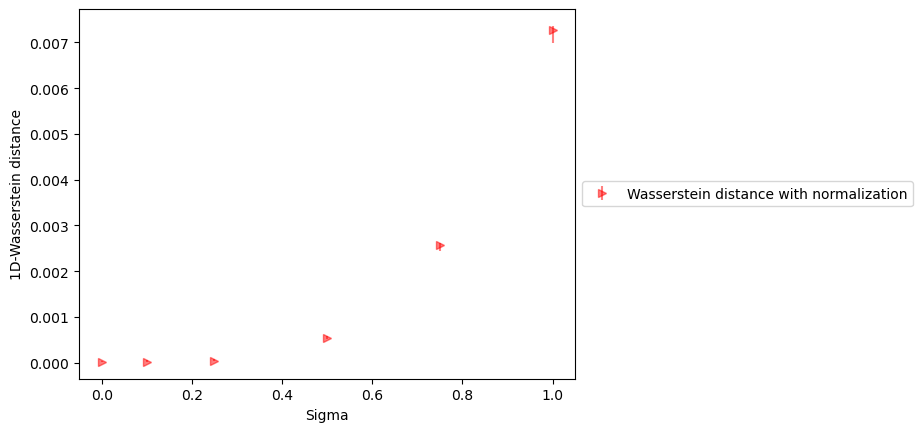

In [11]:
lower_error = min_mmd_scores_every_hl_feature_separately_normalized 
upper_error = max_mmd_scores_every_hl_feature_separately_normalized 
print(lower_error)
print(upper_error)
asym_error_gaussian_smearing_mmd_scores = [lower_error,upper_error]


plt.figure()

plt.errorbar(
    sigma_array_hl,
    median_mmd_scores_every_hl_feature_separately_normalized,
    yerr = asym_error_gaussian_smearing_mmd_scores,
    color="red",
    marker='>',
    alpha=0.5,
    linestyle='none',
    label="Wasserstein distance with normalization",
)

plt.xlabel("Sigma")
plt.ylabel("1D-Wasserstein distance")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()
#plt.savefig(f"/beegfs/desy/user/schreibj/Hadron_classifier/Savings_complete/v5_Wasserstein1D/mmd_score_gaussian_smearing_normalized{str(datetime.now())}.pdf")

GAUSSIAN